In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
print(" GPU cache cleared.")

 GPU cache cleared.


In [ ]:
# If not already: upload kaggle.json to ~/.kaggle (Linux) or set env vars.
# In Jupyter: you can run this once after uploading kaggle.json to the notebook directory.
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

!pip -q install --upgrade kaggle torch torchvision pillow tqdm matplotlib

# Download & unzip the competition data
!kaggle competitions download -c data-266-fall-2025-gan-image-style-transfer -p ./data
!mkdir -p ./data/raw
!unzip -o ./data/*.zip -d ./data/raw > /dev/null

# Inspect directory to confirm structure (adjust as needed for your comp)
!find ./data/raw -maxdepth 2 -type d -print | sort

data-266-fall-2025-gan-image-style-transfer.zip: Skipping, found more recently modified local copy (use --force to force download)
./data/raw
./data/raw/test
./data/raw/test/test
./data/raw/train
./data/raw/train/train


In [ ]:
!pip -q install --upgrade kaggle torch torchvision pillow tqdm matplotlib

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list | head -n 5

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd       1044           False  
https://www.kaggle.com/competitions/jigsaw-agile-community-rules                 2025-10-24 06:59:00  Featured           100,000 Usd       2050           False  
https://www.kaggle.com/competitions/google-code-golf-2025                        2025-10-30 23:59:00  Research           100,000 Usd        865           False  


In [ ]:
!kaggle competitions download -c data-266-fall-2025-gan-image-style-transfer -p ./data

data-266-fall-2025-gan-image-style-transfer.zip: Skipping, found more recently modified local copy (use --force to force download)


### Extracting and Verifying Structure

In [ ]:
!apt-get update && apt-get install -y unzip

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 128 kB in 1s (107 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.2).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [ ]:
!unzip -o ./data/data-266-fall-2025-gan-image-style-transfer.zip -d ./data/raw > /dev/null
!find ./data/raw -maxdepth 2 -type d

./data/raw
./data/raw/test
./data/raw/test/test
./data/raw/train
./data/raw/train/train


### Verifying Contents after download

In [ ]:
!find ./data/raw/train/train -type f | head -n 10
!find ./data/raw/test/test -type f | head -n 10

./data/raw/train/train/1.jpg
./data/raw/train/train/10.jpg
./data/raw/train/train/100.jpg
./data/raw/train/train/1000.jpg
./data/raw/train/train/1001.jpg
./data/raw/train/train/1002.jpg
./data/raw/train/train/1003.jpg
./data/raw/train/train/1004.jpg
./data/raw/train/train/1005.jpg
./data/raw/train/train/1006.jpg
find: ‘standard output’: Broken pipe
find: write error
./data/raw/test/test/1.jpg
./data/raw/test/test/10.jpg
./data/raw/test/test/100.jpg
./data/raw/test/test/101.jpg
./data/raw/test/test/102.jpg
./data/raw/test/test/103.jpg
./data/raw/test/test/104.jpg
./data/raw/test/test/105.jpg
./data/raw/test/test/106.jpg
./data/raw/test/test/107.jpg
find: ‘standard output’: Broken pipe
find: write error


Both `train` and `test` folders each contain a single .jpg per sample and so they are not exactly paired. i want to see what's in the jpg for better understanding because I was expecting it to be in separate “images” and “segmentations” folders.

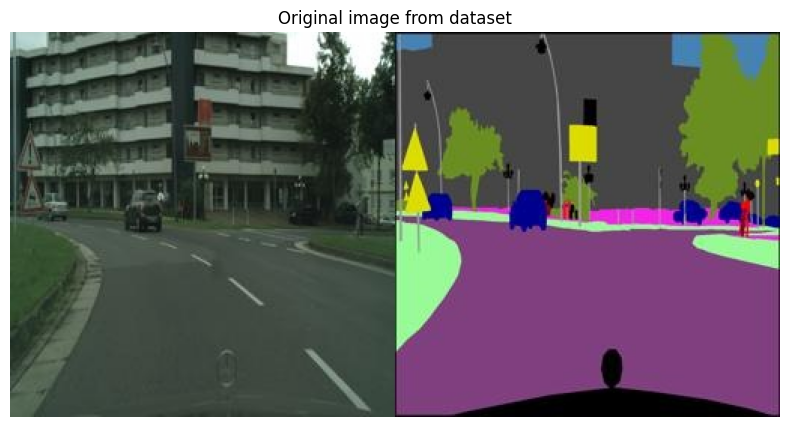

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# pick one image to visualize (e.g., 1.jpg)
img_path = "./data/raw/train/train/1.jpg"

img = Image.open(img_path)
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.axis("off")
plt.title("Original image from dataset")
plt.show()

So, now it is confirm that we have a side-by-side image pair:

- `Left half` → Real photo (street scene)

- `Right half` : Segmentation mask (color-coded labels)


The __Training direction__ should be `"seg2photo"` for segemntation to colored photo and the image size is 256*256.

## Setup Checkup

In [ ]:
import warnings, os
warnings.filterwarnings("ignore")
os.environ["PIP_DISABLE_PIP_VERSION_CHECK"] = "1"
os.environ["PYTHONWARNINGS"] = "ignore"

!pip install --quiet torch torchvision tqdm matplotlib pillow

In [ ]:
import torch, torchvision
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

2.8.0+cu128
Device: cuda


## Installing Necessary Libraries

In [ ]:
!pip install scikit-image --quiet

In [ ]:
import os, random, glob, math, csv
from pathlib import Path
from typing import Tuple
from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

## Configuration

In [ ]:
TRAIN_DIR = "./data/raw/train/train"
VAL_DIR   = "./data/raw/test/test"     # using "test" as our validation/eval source (side-by-side visible)
SAMPLE_DIR = OUTDIR / "samples"; SAMPLE_DIR.mkdir(exist_ok=True)
OUTDIR    = Path("./outputs"); OUTDIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR  = OUTDIR/"checkpoints"; CKPT_DIR.mkdir(exist_ok=True)
PRED_DIR  = OUTDIR/"pred"; PRED_DIR.mkdir(exist_ok=True)

IMG_SIZE     = 256           #256
BATCH_SIZE   = 4
NUM_WORKERS  = 4
EPOCHS       = 200
LR           = 0.0002
BETA1, BETA2 = 0.5, 0.999
LAMBDA_L1    = 100.0
DIRECTION    = "seg2photo"   # discussed above

## Transforming the Dataset using Random Jitter
 Random jitter (resize slightly larger + random crop back) and horizontal flip for augmentation.

In [ ]:
from torchvision import transforms
import random

class RandomJitter:
    def __init__(self, size=256, resize_to=286):
        self.size = size
        self.resize_to = resize_to
    def __call__(self, img):
        img = transforms.Resize((self.resize_to, self.resize_to))(img)
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.size, self.size))
        img = transforms.functional.crop(img, i, j, h, w)
        if random.random() > 0.5:
            img = transforms.functional.hflip(img)
        return img

## Data Pipeline
    
- Each .jpg is horizontally [photo | seg] but as per problem statement, we want seg -> photo.

- So. we will feed the RIGHT half (seg) as condition and the LEFT half (photo) as target.

In [ ]:
class SideBySideDataset(Dataset):
    def __init__(self, root_dir, direction="seg2photo", augment=True, img_size=256):
        self.files = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(".jpg")])
        self.direction = direction
        self.augment = augment
        self.rj = RandomJitter(img_size, resize_to=286)
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        p = self.files[idx]
        img = Image.open(p).convert("RGB")
        w, h = img.size
        w2 = w // 2
        photo = img.crop((0, 0, w2, h))     # left
        seg   = img.crop((w2, 0, w, h))     # right

        if self.direction == "seg2photo":
            cond, target = seg, photo
        else:
            cond, target = photo, seg

        if self.augment:
            seed = torch.randint(0, 2**32, (1,)).item()
            random.seed(seed); cond   = self.rj(cond)
            random.seed(seed); target = self.rj(target)

        cond   = self.to_tensor(cond)
        target = self.to_tensor(target)
        name = os.path.basename(p)
        return cond, target, name

train_ds = SideBySideDataset(TRAIN_DIR, direction=DIRECTION, augment=True,  img_size=IMG_SIZE)
val_ds   = SideBySideDataset(VAL_DIR,   direction=DIRECTION, augment=False, img_size=IMG_SIZE)

BATCH_SIZE = 4
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False,
                          num_workers=0, pin_memory=True)

print(f"Train: {len(train_ds)} | Val(Test): {len(val_ds)}")

Train: 2975 | Val(Test): 500


In [ ]:
ds = SideBySideDataset("./data/raw/train/train", direction="seg2photo", augment=True)
imgA, imgB, _ = ds[0]
print("Image shapes:", imgA.shape, imgB.shape)

Image shapes: torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


## Building the Architecture of CGAN : U-Net Generator and 70×70 PatchGAN Discriminator

#### (1) Defining Conv layers as building blocks for the model

In [ ]:
import torch.nn as nn

def conv_block(in_c, out_c, norm=True):
    layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=not norm)]
    if norm: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

def deconv_block(in_c, out_c, dropout=False):
    layers = [nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
              nn.BatchNorm2d(out_c),
              nn.ReLU(inplace=True)]
    if dropout: layers.append(nn.Dropout(0.5))
    return nn.Sequential(*layers)

#### (2) U-Net Generator (8 down/8 up for 256x256)

In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv2d(in_ch, 64, 4, 2, 1), nn.LeakyReLU(0.2, True))
        self.down2 = conv_block(64, 128)
        self.down3 = conv_block(128, 256)
        self.down4 = conv_block(256, 512)
        self.down5 = conv_block(512, 512)
        self.down6 = conv_block(512, 512)
        self.down7 = conv_block(512, 512)
        self.down8 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(True))

        self.up1 = deconv_block(512, 512, dropout=True)
        self.up2 = deconv_block(1024, 512, dropout=True)
        self.up3 = deconv_block(1024, 512, dropout=True)
        self.up4 = deconv_block(1024, 512)
        self.up5 = deconv_block(1024, 256)
        self.up6 = deconv_block(512, 128)
        self.up7 = deconv_block(256, 64)
        self.up8 = nn.ConvTranspose2d(128, out_ch, 4, 2, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        d1 = self.down1(x); d2 = self.down2(d1); d3 = self.down3(d2); d4 = self.down4(d3)
        d5 = self.down5(d4); d6 = self.down6(d5); d7 = self.down7(d6); d8 = self.down8(d7)
        u1 = self.up1(d8);  u1 = torch.cat([u1, d7], 1)
        u2 = self.up2(u1);  u2 = torch.cat([u2, d6], 1)
        u3 = self.up3(u2);  u3 = torch.cat([u3, d5], 1)
        u4 = self.up4(u3);  u4 = torch.cat([u4, d4], 1)
        u5 = self.up5(u4);  u5 = torch.cat([u5, d3], 1)
        u6 = self.up6(u5);  u6 = torch.cat([u6, d2], 1)
        u7 = self.up7(u6);  u7 = torch.cat([u7, d1], 1)
        u8 = self.up8(u7)
        return self.tanh(u8)

#### (3) 70x70 PatchGAN Discriminator

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1), nn.LeakyReLU(0.2, True),
            conv_block(64, 128),
            conv_block(128, 256),
            nn.Conv2d(256, 512, 4, 1, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 1, 4, 1, 1)  # logits
        )
    def forward(self, x): return self.net(x)

In [ ]:
# import torch.nn.utils as utils

# class PatchDiscriminator(nn.Module):
#     def __init__(self, in_ch=6):
#         super().__init__()
#         self.net = nn.Sequential(
#             utils.spectral_norm(nn.Conv2d(in_ch, 64, 4, 2, 1)),
#             nn.LeakyReLU(0.2, True),

#             utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
#             nn.InstanceNorm2d(128, affine=True),
#             nn.LeakyReLU(0.2, True),

#             utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
#             nn.InstanceNorm2d(256, affine=True),
#             nn.LeakyReLU(0.2, True),

#             utils.spectral_norm(nn.Conv2d(256, 512, 4, 1, 1, bias=False)),
#             nn.InstanceNorm2d(512, affine=True),
#             nn.LeakyReLU(0.2, True),

#             utils.spectral_norm(nn.Conv2d(512, 1, 4, 1, 1))
#         )
#     def forward(self, x): return self.net(x)

In [ ]:
G = UNetGenerator(in_ch=3, out_ch=3).to(device)
D = PatchDiscriminator(in_ch=6).to(device)

#### (4) Losses and Optimizers

In [ ]:
adv_criterion = nn.BCEWithLogitsLoss()
l1_criterion  = nn.L1Loss()

def denorm(x): return (x*0.5 + 0.5).clamp(0,1)

In [ ]:
# from torchvision.models import vgg16, VGG16_Weights

# LAMBDA_L1 = 70.0
# LAMBDA_FM = 1.0
# LAMBDA_PERCEPT = 1.0

# # VGG16 perceptual loss
# vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_FEATURES).features[:16].eval().to(device)
# for p in vgg.parameters():
#     p.requires_grad = False

# def perceptual_loss(fake, real):
#     return l1_criterion(vgg(fake), vgg(real))

# # Extract intermediate discriminator features for feature-matching
# def extract_D_features(D, x):
#     feats = []
#     for layer in list(D.net)[:-1]:
#         x = layer(x)
#         feats.append(x)
#     return feats

#### (5) Learning Rate Schedulers and Optimizers

In [ ]:
opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, BETA2))

# Learning rate schedulers (decay LR by half every 100 epochs)
scheduler_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=100, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=100, gamma=0.5)

In [ ]:
# LR_G, LR_D = 0.0002,  0.0001
# BETA1, BETA2 = 0.5, 0.999

# opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=(BETA1, BETA2))
# opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=(BETA1, BETA2))

# scheduler_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=100, gamma=0.5)
# scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=100, gamma=0.5)

#### (6) Defining the Train Specifics for Discriminator and Generator

In [ ]:
global_step = 0
# for epoch in range(1, EPOCHS+1):
#     G.train(); D.train()
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
#     for cond, target, names in pbar:
#         cond, target = cond.to(device), target.to(device)
best_fid = float("inf")

G_losses, D_losses, LRs = [], [], []

for epoch in range(1, EPOCHS + 1):
    G.train(); D.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for cond, target, _ in pbar:
        cond, target = cond.to(device), target.to(device)
        global_step += 1

        # Train Discriminator
        opt_D.zero_grad()
        real_pair = torch.cat([cond, target], 1)
        pred_real = D(real_pair)
        fake_img  = G(cond).detach()
        fake_pair = torch.cat([cond, fake_img], 1)
        pred_fake = D(fake_pair)
        loss_D = 0.5*(adv_criterion(pred_real, torch.ones_like(pred_real)) +
                      adv_criterion(pred_fake, torch.zeros_like(pred_fake)))
        loss_D.backward()
        opt_D.step()

        # Train Generator
        opt_G.zero_grad()
        gen_img = G(cond)
        gen_pair = torch.cat([cond, gen_img], 1)
        pred_gen = D(gen_pair)
        # Adversarial Step (want Discrimantor to think Generated images for Generator is real)
        loss_G_GAN = adv_criterion(pred_gen, torch.ones_like(pred_gen))
        # L1 reconstruction loss (pixel-level)
        loss_G_L1 = l1_criterion(gen_img, target) * LAMBDA_L1
        # Extract intermediate discriminator features for feature-matching
        def extract_features(model, x):
            feats = []
            for layer in model.net[:-1]:  # exclude final conv layer
                x = layer(x)
                feats.append(x)
            return feats
        real_feats = extract_features(D, real_pair.detach())
        fake_feats = extract_features(D, gen_pair)

        feature_loss = 0
        for rf, ff in zip(real_feats, fake_feats):
            feature_loss += l1_criterion(ff, rf) * 10.0
        # total generator loss
        loss_G = loss_G_GAN + loss_G_L1 + feature_loss
        loss_G.backward()
        opt_G.step()
        pbar.set_postfix(D=loss_D.item(), G=loss_G.item())


    # step the lR schedulers (after each epoch)
    scheduler_G.step()
    scheduler_D.step()

    current_lr = scheduler_G.get_last_lr()[0]
    print(f"\nEpoch {epoch} done. Now training with LR: {current_lr:.6f}")

    # save checkpoint at every 10 epoch
    if epoch % 10 == 0:
        ckpt_path = CKPT_DIR / f"epoch_{epoch}.pt"
        torch.save({
            "G": G.state_dict(),
            "D": D.state_dict(),
            "epoch": epoch
        }, ckpt_path)
        print(f"\nSaved checkpoint: {ckpt_path}")
print("Training complete.")

Epoch 1/300: 100%|██████████| 743/743 [00:17<00:00, 42.79it/s, D=0.25, G=32.6]  



Epoch 1 done. Now training with LR: 0.000200


Epoch 2/300: 100%|██████████| 743/743 [00:16<00:00, 44.06it/s, D=0.263, G=28.3] 



Epoch 2 done. Now training with LR: 0.000200


Epoch 3/300: 100%|██████████| 743/743 [00:16<00:00, 45.27it/s, D=0.278, G=28.2] 



Epoch 3 done. Now training with LR: 0.000200


Epoch 4/300: 100%|██████████| 743/743 [00:16<00:00, 45.68it/s, D=0.464, G=21.9] 



Epoch 4 done. Now training with LR: 0.000200


Epoch 5/300: 100%|██████████| 743/743 [00:16<00:00, 44.71it/s, D=0.0752, G=27.3]



Epoch 5 done. Now training with LR: 0.000200


Epoch 6/300: 100%|██████████| 743/743 [00:16<00:00, 44.37it/s, D=0.527, G=23]   



Epoch 6 done. Now training with LR: 0.000200


Epoch 7/300: 100%|██████████| 743/743 [00:16<00:00, 45.34it/s, D=0.21, G=28.1]  



Epoch 7 done. Now training with LR: 0.000200


Epoch 8/300: 100%|██████████| 743/743 [00:16<00:00, 44.70it/s, D=0.311, G=30]   



Epoch 8 done. Now training with LR: 0.000200


Epoch 9/300: 100%|██████████| 743/743 [00:17<00:00, 42.95it/s, D=0.0664, G=28.8]



Epoch 9 done. Now training with LR: 0.000200


Epoch 10/300: 100%|██████████| 743/743 [00:17<00:00, 43.46it/s, D=0.751, G=27.2] 



Epoch 10 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_10.pt


Epoch 11/300: 100%|██████████| 743/743 [00:16<00:00, 44.55it/s, D=0.21, G=27.1]  



Epoch 11 done. Now training with LR: 0.000200


Epoch 12/300: 100%|██████████| 743/743 [00:16<00:00, 44.51it/s, D=1.35, G=24.9]  



Epoch 12 done. Now training with LR: 0.000200


Epoch 13/300: 100%|██████████| 743/743 [00:16<00:00, 44.78it/s, D=0.15, G=23.8]  



Epoch 13 done. Now training with LR: 0.000200


Epoch 14/300: 100%|██████████| 743/743 [00:16<00:00, 44.55it/s, D=0.824, G=27.5] 



Epoch 14 done. Now training with LR: 0.000200


Epoch 15/300: 100%|██████████| 743/743 [00:16<00:00, 44.61it/s, D=0.321, G=30.6] 



Epoch 15 done. Now training with LR: 0.000200


Epoch 16/300: 100%|██████████| 743/743 [00:16<00:00, 44.35it/s, D=0.149, G=25.3] 



Epoch 16 done. Now training with LR: 0.000200


Epoch 17/300: 100%|██████████| 743/743 [00:16<00:00, 43.85it/s, D=0.361, G=26.2] 



Epoch 17 done. Now training with LR: 0.000200


Epoch 18/300: 100%|██████████| 743/743 [00:16<00:00, 45.24it/s, D=0.158, G=30.9] 



Epoch 18 done. Now training with LR: 0.000200


Epoch 19/300: 100%|██████████| 743/743 [00:16<00:00, 43.94it/s, D=0.883, G=21.7] 



Epoch 19 done. Now training with LR: 0.000200


Epoch 20/300: 100%|██████████| 743/743 [00:16<00:00, 45.05it/s, D=0.282, G=26.1] 



Epoch 20 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_20.pt


Epoch 21/300: 100%|██████████| 743/743 [00:16<00:00, 44.45it/s, D=0.096, G=34.5] 



Epoch 21 done. Now training with LR: 0.000200


Epoch 22/300: 100%|██████████| 743/743 [00:16<00:00, 44.70it/s, D=2.15, G=27]    



Epoch 22 done. Now training with LR: 0.000200


Epoch 23/300: 100%|██████████| 743/743 [00:16<00:00, 44.61it/s, D=0.734, G=21.1] 



Epoch 23 done. Now training with LR: 0.000200


Epoch 24/300: 100%|██████████| 743/743 [00:16<00:00, 44.69it/s, D=0.604, G=27.1] 



Epoch 24 done. Now training with LR: 0.000200


Epoch 25/300: 100%|██████████| 743/743 [00:16<00:00, 43.76it/s, D=0.645, G=29]   



Epoch 25 done. Now training with LR: 0.000200


Epoch 26/300: 100%|██████████| 743/743 [00:16<00:00, 44.25it/s, D=0.853, G=21.2] 



Epoch 26 done. Now training with LR: 0.000200


Epoch 27/300: 100%|██████████| 743/743 [00:17<00:00, 43.12it/s, D=0.399, G=22.7] 



Epoch 27 done. Now training with LR: 0.000200


Epoch 28/300: 100%|██████████| 743/743 [00:17<00:00, 43.25it/s, D=1.09, G=22.6]  



Epoch 28 done. Now training with LR: 0.000200


Epoch 29/300: 100%|██████████| 743/743 [00:17<00:00, 42.57it/s, D=0.945, G=24.5] 



Epoch 29 done. Now training with LR: 0.000200


Epoch 30/300: 100%|██████████| 743/743 [00:16<00:00, 44.36it/s, D=0.61, G=20.2]  



Epoch 30 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_30.pt


Epoch 31/300: 100%|██████████| 743/743 [00:17<00:00, 42.85it/s, D=0.747, G=19.5] 



Epoch 31 done. Now training with LR: 0.000200


Epoch 32/300: 100%|██████████| 743/743 [00:17<00:00, 42.93it/s, D=0.33, G=24.3]  



Epoch 32 done. Now training with LR: 0.000200


Epoch 33/300: 100%|██████████| 743/743 [00:17<00:00, 42.88it/s, D=0.478, G=23.8] 



Epoch 33 done. Now training with LR: 0.000200


Epoch 34/300: 100%|██████████| 743/743 [00:17<00:00, 43.26it/s, D=0.168, G=25.1] 



Epoch 34 done. Now training with LR: 0.000200


Epoch 35/300: 100%|██████████| 743/743 [00:17<00:00, 43.57it/s, D=0.211, G=27.9] 



Epoch 35 done. Now training with LR: 0.000200


Epoch 36/300: 100%|██████████| 743/743 [00:17<00:00, 42.96it/s, D=0.288, G=27.4] 



Epoch 36 done. Now training with LR: 0.000200


Epoch 37/300: 100%|██████████| 743/743 [00:17<00:00, 43.16it/s, D=1.63, G=22.2]  



Epoch 37 done. Now training with LR: 0.000200


Epoch 38/300: 100%|██████████| 743/743 [00:17<00:00, 43.68it/s, D=0.703, G=24.5] 



Epoch 38 done. Now training with LR: 0.000200


Epoch 39/300: 100%|██████████| 743/743 [00:17<00:00, 42.56it/s, D=0.317, G=25.2] 



Epoch 39 done. Now training with LR: 0.000200


Epoch 40/300: 100%|██████████| 743/743 [00:17<00:00, 42.52it/s, D=0.369, G=27.2] 



Epoch 40 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_40.pt


Epoch 41/300: 100%|██████████| 743/743 [00:17<00:00, 43.07it/s, D=0.257, G=23.8] 



Epoch 41 done. Now training with LR: 0.000200


Epoch 42/300: 100%|██████████| 743/743 [00:17<00:00, 42.85it/s, D=0.304, G=21.9] 



Epoch 42 done. Now training with LR: 0.000200


Epoch 43/300: 100%|██████████| 743/743 [00:17<00:00, 43.16it/s, D=0.327, G=24]   



Epoch 43 done. Now training with LR: 0.000200


Epoch 44/300: 100%|██████████| 743/743 [00:17<00:00, 42.90it/s, D=0.354, G=25.3] 



Epoch 44 done. Now training with LR: 0.000200


Epoch 45/300: 100%|██████████| 743/743 [00:17<00:00, 43.15it/s, D=0.14, G=25.1]  



Epoch 45 done. Now training with LR: 0.000200


Epoch 46/300: 100%|██████████| 743/743 [00:16<00:00, 43.87it/s, D=0.482, G=23]   



Epoch 46 done. Now training with LR: 0.000200


Epoch 47/300: 100%|██████████| 743/743 [00:16<00:00, 43.75it/s, D=0.747, G=24.8] 



Epoch 47 done. Now training with LR: 0.000200


Epoch 48/300: 100%|██████████| 743/743 [00:16<00:00, 44.01it/s, D=0.265, G=24.4] 



Epoch 48 done. Now training with LR: 0.000200


Epoch 49/300: 100%|██████████| 743/743 [00:16<00:00, 43.83it/s, D=0.873, G=23.9] 



Epoch 49 done. Now training with LR: 0.000200


Epoch 50/300: 100%|██████████| 743/743 [00:17<00:00, 42.16it/s, D=0.383, G=23.3] 



Epoch 50 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_50.pt


Epoch 51/300: 100%|██████████| 743/743 [00:16<00:00, 43.86it/s, D=0.444, G=26.5] 



Epoch 51 done. Now training with LR: 0.000200


Epoch 52/300: 100%|██████████| 743/743 [00:16<00:00, 44.35it/s, D=0.352, G=22.6] 



Epoch 52 done. Now training with LR: 0.000200


Epoch 53/300: 100%|██████████| 743/743 [00:17<00:00, 42.88it/s, D=0.346, G=19.6] 



Epoch 53 done. Now training with LR: 0.000200


Epoch 54/300: 100%|██████████| 743/743 [00:17<00:00, 43.69it/s, D=0.351, G=23.1] 



Epoch 54 done. Now training with LR: 0.000200


Epoch 55/300: 100%|██████████| 743/743 [00:17<00:00, 43.52it/s, D=0.378, G=27]   



Epoch 55 done. Now training with LR: 0.000200


Epoch 56/300: 100%|██████████| 743/743 [00:17<00:00, 43.57it/s, D=0.0916, G=31.1]



Epoch 56 done. Now training with LR: 0.000200


Epoch 57/300: 100%|██████████| 743/743 [00:16<00:00, 44.11it/s, D=0.269, G=24.8] 



Epoch 57 done. Now training with LR: 0.000200


Epoch 58/300: 100%|██████████| 743/743 [00:17<00:00, 42.36it/s, D=1.41, G=22.2]  



Epoch 58 done. Now training with LR: 0.000200


Epoch 59/300: 100%|██████████| 743/743 [00:17<00:00, 43.21it/s, D=0.376, G=24.2] 



Epoch 59 done. Now training with LR: 0.000200


Epoch 60/300: 100%|██████████| 743/743 [00:16<00:00, 44.10it/s, D=0.297, G=29.2] 



Epoch 60 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_60.pt


Epoch 61/300: 100%|██████████| 743/743 [00:17<00:00, 42.72it/s, D=0.478, G=24.5] 



Epoch 61 done. Now training with LR: 0.000200


Epoch 62/300: 100%|██████████| 743/743 [00:16<00:00, 43.97it/s, D=0.356, G=24.7] 



Epoch 62 done. Now training with LR: 0.000200


Epoch 63/300: 100%|██████████| 743/743 [00:16<00:00, 44.07it/s, D=0.55, G=25]    



Epoch 63 done. Now training with LR: 0.000200


Epoch 64/300: 100%|██████████| 743/743 [00:17<00:00, 43.18it/s, D=0.0775, G=30.4]



Epoch 64 done. Now training with LR: 0.000200


Epoch 65/300: 100%|██████████| 743/743 [00:16<00:00, 44.34it/s, D=0.0733, G=29.8]



Epoch 65 done. Now training with LR: 0.000200


Epoch 66/300: 100%|██████████| 743/743 [00:16<00:00, 45.40it/s, D=0.362, G=25.2] 



Epoch 66 done. Now training with LR: 0.000200


Epoch 67/300: 100%|██████████| 743/743 [00:16<00:00, 44.45it/s, D=0.082, G=26.5] 



Epoch 67 done. Now training with LR: 0.000200


Epoch 68/300: 100%|██████████| 743/743 [00:16<00:00, 45.89it/s, D=0.916, G=22]   



Epoch 68 done. Now training with LR: 0.000200


Epoch 69/300: 100%|██████████| 743/743 [00:17<00:00, 43.05it/s, D=0.598, G=21.5] 



Epoch 69 done. Now training with LR: 0.000200


Epoch 70/300: 100%|██████████| 743/743 [00:16<00:00, 44.90it/s, D=0.611, G=23.5] 



Epoch 70 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_70.pt


Epoch 71/300: 100%|██████████| 743/743 [00:16<00:00, 44.42it/s, D=0.097, G=23.6] 



Epoch 71 done. Now training with LR: 0.000200


Epoch 72/300: 100%|██████████| 743/743 [00:16<00:00, 45.06it/s, D=0.43, G=24.5]  



Epoch 72 done. Now training with LR: 0.000200


Epoch 73/300: 100%|██████████| 743/743 [00:16<00:00, 45.53it/s, D=0.319, G=22.8] 



Epoch 73 done. Now training with LR: 0.000200


Epoch 74/300: 100%|██████████| 743/743 [00:16<00:00, 44.97it/s, D=0.509, G=22.9] 



Epoch 74 done. Now training with LR: 0.000200


Epoch 75/300: 100%|██████████| 743/743 [00:16<00:00, 44.57it/s, D=0.472, G=19.5] 



Epoch 75 done. Now training with LR: 0.000200


Epoch 76/300: 100%|██████████| 743/743 [00:16<00:00, 44.84it/s, D=0.199, G=25]   



Epoch 76 done. Now training with LR: 0.000200


Epoch 77/300: 100%|██████████| 743/743 [00:16<00:00, 44.59it/s, D=0.503, G=22.9] 



Epoch 77 done. Now training with LR: 0.000200


Epoch 78/300: 100%|██████████| 743/743 [00:16<00:00, 45.16it/s, D=0.562, G=21]   



Epoch 78 done. Now training with LR: 0.000200


Epoch 79/300: 100%|██████████| 743/743 [00:16<00:00, 44.66it/s, D=0.474, G=19.6] 



Epoch 79 done. Now training with LR: 0.000200


Epoch 80/300: 100%|██████████| 743/743 [00:16<00:00, 45.22it/s, D=0.415, G=25.1] 



Epoch 80 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_80.pt


Epoch 81/300: 100%|██████████| 743/743 [00:16<00:00, 45.39it/s, D=0.469, G=26.4] 



Epoch 81 done. Now training with LR: 0.000200


Epoch 82/300: 100%|██████████| 743/743 [00:16<00:00, 44.98it/s, D=0.438, G=29.3] 



Epoch 82 done. Now training with LR: 0.000200


Epoch 83/300: 100%|██████████| 743/743 [00:16<00:00, 45.54it/s, D=0.371, G=27.3] 



Epoch 83 done. Now training with LR: 0.000200


Epoch 84/300: 100%|██████████| 743/743 [00:16<00:00, 44.88it/s, D=0.368, G=18.4] 



Epoch 84 done. Now training with LR: 0.000200


Epoch 85/300: 100%|██████████| 743/743 [00:16<00:00, 45.61it/s, D=0.625, G=22.2] 



Epoch 85 done. Now training with LR: 0.000200


Epoch 86/300: 100%|██████████| 743/743 [00:16<00:00, 45.89it/s, D=0.686, G=21.2] 



Epoch 86 done. Now training with LR: 0.000200


Epoch 87/300: 100%|██████████| 743/743 [00:16<00:00, 44.82it/s, D=0.225, G=23.6] 



Epoch 87 done. Now training with LR: 0.000200


Epoch 88/300: 100%|██████████| 743/743 [00:16<00:00, 45.33it/s, D=0.751, G=19]   



Epoch 88 done. Now training with LR: 0.000200


Epoch 89/300: 100%|██████████| 743/743 [00:16<00:00, 45.39it/s, D=0.196, G=27.6] 



Epoch 89 done. Now training with LR: 0.000200


Epoch 90/300: 100%|██████████| 743/743 [00:16<00:00, 45.30it/s, D=0.938, G=23.1] 



Epoch 90 done. Now training with LR: 0.000200

Saved checkpoint: outputs/checkpoints/epoch_90.pt


Epoch 91/300: 100%|██████████| 743/743 [00:16<00:00, 43.82it/s, D=0.533, G=20.4] 



Epoch 91 done. Now training with LR: 0.000200


Epoch 92/300: 100%|██████████| 743/743 [00:16<00:00, 45.03it/s, D=0.228, G=20.3] 



Epoch 92 done. Now training with LR: 0.000200


Epoch 93/300: 100%|██████████| 743/743 [00:16<00:00, 44.06it/s, D=0.315, G=25]   



Epoch 93 done. Now training with LR: 0.000200


Epoch 94/300: 100%|██████████| 743/743 [00:16<00:00, 44.13it/s, D=0.317, G=24.8] 



Epoch 94 done. Now training with LR: 0.000200


Epoch 95/300: 100%|██████████| 743/743 [00:16<00:00, 45.08it/s, D=0.36, G=21.2]  



Epoch 95 done. Now training with LR: 0.000200


Epoch 96/300: 100%|██████████| 743/743 [00:16<00:00, 44.62it/s, D=0.425, G=21]   



Epoch 96 done. Now training with LR: 0.000200


Epoch 97/300: 100%|██████████| 743/743 [00:16<00:00, 44.79it/s, D=0.43, G=21]    



Epoch 97 done. Now training with LR: 0.000200


Epoch 98/300: 100%|██████████| 743/743 [00:16<00:00, 45.23it/s, D=0.215, G=21.3] 



Epoch 98 done. Now training with LR: 0.000200


Epoch 99/300: 100%|██████████| 743/743 [00:17<00:00, 43.70it/s, D=0.28, G=24]    



Epoch 99 done. Now training with LR: 0.000200


Epoch 100/300: 100%|██████████| 743/743 [00:16<00:00, 44.98it/s, D=0.259, G=22.4] 



Epoch 100 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_100.pt


Epoch 101/300: 100%|██████████| 743/743 [00:16<00:00, 44.31it/s, D=0.173, G=22.6] 



Epoch 101 done. Now training with LR: 0.000100


Epoch 102/300: 100%|██████████| 743/743 [00:16<00:00, 44.04it/s, D=0.403, G=20.9] 



Epoch 102 done. Now training with LR: 0.000100


Epoch 103/300: 100%|██████████| 743/743 [00:17<00:00, 41.83it/s, D=0.472, G=21]   



Epoch 103 done. Now training with LR: 0.000100


Epoch 104/300: 100%|██████████| 743/743 [00:17<00:00, 42.52it/s, D=0.197, G=21.8] 



Epoch 104 done. Now training with LR: 0.000100


Epoch 105/300: 100%|██████████| 743/743 [00:17<00:00, 43.41it/s, D=0.46, G=18.9]  



Epoch 105 done. Now training with LR: 0.000100


Epoch 106/300: 100%|██████████| 743/743 [00:17<00:00, 42.25it/s, D=0.315, G=22.1] 



Epoch 106 done. Now training with LR: 0.000100


Epoch 107/300: 100%|██████████| 743/743 [00:16<00:00, 43.76it/s, D=0.553, G=19.1] 



Epoch 107 done. Now training with LR: 0.000100


Epoch 108/300: 100%|██████████| 743/743 [00:17<00:00, 42.04it/s, D=0.243, G=23.1] 



Epoch 108 done. Now training with LR: 0.000100


Epoch 109/300: 100%|██████████| 743/743 [00:17<00:00, 42.89it/s, D=0.285, G=23.2] 



Epoch 109 done. Now training with LR: 0.000100


Epoch 110/300: 100%|██████████| 743/743 [00:16<00:00, 44.25it/s, D=0.447, G=19.8] 



Epoch 110 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_110.pt


Epoch 111/300: 100%|██████████| 743/743 [00:16<00:00, 44.58it/s, D=0.212, G=19.8] 



Epoch 111 done. Now training with LR: 0.000100


Epoch 112/300: 100%|██████████| 743/743 [00:16<00:00, 44.20it/s, D=0.25, G=23.8]  



Epoch 112 done. Now training with LR: 0.000100


Epoch 113/300: 100%|██████████| 743/743 [00:16<00:00, 44.45it/s, D=0.271, G=22.9] 



Epoch 113 done. Now training with LR: 0.000100


Epoch 114/300: 100%|██████████| 743/743 [00:16<00:00, 44.20it/s, D=0.551, G=20.5] 



Epoch 114 done. Now training with LR: 0.000100


Epoch 115/300: 100%|██████████| 743/743 [00:16<00:00, 45.00it/s, D=0.369, G=20.7] 



Epoch 115 done. Now training with LR: 0.000100


Epoch 116/300: 100%|██████████| 743/743 [00:16<00:00, 45.43it/s, D=0.546, G=21.7] 



Epoch 116 done. Now training with LR: 0.000100


Epoch 117/300: 100%|██████████| 743/743 [00:16<00:00, 45.15it/s, D=0.457, G=21.6] 



Epoch 117 done. Now training with LR: 0.000100


Epoch 118/300: 100%|██████████| 743/743 [00:16<00:00, 43.98it/s, D=0.236, G=22.4] 



Epoch 118 done. Now training with LR: 0.000100


Epoch 119/300: 100%|██████████| 743/743 [00:17<00:00, 43.52it/s, D=0.173, G=23.3] 



Epoch 119 done. Now training with LR: 0.000100


Epoch 120/300: 100%|██████████| 743/743 [00:17<00:00, 42.25it/s, D=0.227, G=25]   



Epoch 120 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_120.pt


Epoch 121/300: 100%|██████████| 743/743 [00:17<00:00, 42.84it/s, D=0.466, G=19.5] 



Epoch 121 done. Now training with LR: 0.000100


Epoch 122/300: 100%|██████████| 743/743 [00:16<00:00, 45.19it/s, D=0.501, G=17.9] 



Epoch 122 done. Now training with LR: 0.000100


Epoch 123/300: 100%|██████████| 743/743 [00:16<00:00, 45.30it/s, D=0.647, G=21]   



Epoch 123 done. Now training with LR: 0.000100


Epoch 124/300: 100%|██████████| 743/743 [00:16<00:00, 45.01it/s, D=0.39, G=20.9]  



Epoch 124 done. Now training with LR: 0.000100


Epoch 125/300: 100%|██████████| 743/743 [00:16<00:00, 45.09it/s, D=0.743, G=16.9] 



Epoch 125 done. Now training with LR: 0.000100


Epoch 126/300: 100%|██████████| 743/743 [00:16<00:00, 43.98it/s, D=0.32, G=23.9]  



Epoch 126 done. Now training with LR: 0.000100


Epoch 127/300: 100%|██████████| 743/743 [00:16<00:00, 45.43it/s, D=0.681, G=19.6] 



Epoch 127 done. Now training with LR: 0.000100


Epoch 128/300: 100%|██████████| 743/743 [00:16<00:00, 45.41it/s, D=0.992, G=26.3] 



Epoch 128 done. Now training with LR: 0.000100


Epoch 129/300: 100%|██████████| 743/743 [00:17<00:00, 43.70it/s, D=0.457, G=21.5]



Epoch 129 done. Now training with LR: 0.000100


Epoch 130/300: 100%|██████████| 743/743 [00:16<00:00, 43.80it/s, D=0.252, G=21]   



Epoch 130 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_130.pt


Epoch 131/300: 100%|██████████| 743/743 [00:16<00:00, 45.71it/s, D=0.926, G=18.6] 



Epoch 131 done. Now training with LR: 0.000100


Epoch 132/300: 100%|██████████| 743/743 [00:16<00:00, 44.37it/s, D=0.347, G=17.8] 



Epoch 132 done. Now training with LR: 0.000100


Epoch 133/300: 100%|██████████| 743/743 [00:16<00:00, 44.83it/s, D=0.409, G=20.1] 



Epoch 133 done. Now training with LR: 0.000100


Epoch 134/300: 100%|██████████| 743/743 [00:16<00:00, 44.92it/s, D=0.345, G=19.1] 



Epoch 134 done. Now training with LR: 0.000100


Epoch 135/300: 100%|██████████| 743/743 [00:16<00:00, 45.08it/s, D=0.287, G=20.5] 



Epoch 135 done. Now training with LR: 0.000100


Epoch 136/300: 100%|██████████| 743/743 [00:16<00:00, 44.61it/s, D=0.614, G=24.4] 



Epoch 136 done. Now training with LR: 0.000100


Epoch 137/300: 100%|██████████| 743/743 [00:16<00:00, 45.03it/s, D=0.153, G=22.4] 



Epoch 137 done. Now training with LR: 0.000100


Epoch 138/300: 100%|██████████| 743/743 [00:16<00:00, 45.24it/s, D=0.835, G=19.1] 



Epoch 138 done. Now training with LR: 0.000100


Epoch 139/300: 100%|██████████| 743/743 [00:16<00:00, 44.94it/s, D=0.308, G=21]   



Epoch 139 done. Now training with LR: 0.000100


Epoch 140/300: 100%|██████████| 743/743 [00:16<00:00, 44.39it/s, D=0.295, G=20.9] 



Epoch 140 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_140.pt


Epoch 141/300: 100%|██████████| 743/743 [00:16<00:00, 44.42it/s, D=0.325, G=20.8] 



Epoch 141 done. Now training with LR: 0.000100


Epoch 142/300: 100%|██████████| 743/743 [00:16<00:00, 44.90it/s, D=0.137, G=21.6] 



Epoch 142 done. Now training with LR: 0.000100


Epoch 143/300: 100%|██████████| 743/743 [00:16<00:00, 45.42it/s, D=0.353, G=24.2] 



Epoch 143 done. Now training with LR: 0.000100


Epoch 144/300: 100%|██████████| 743/743 [00:16<00:00, 44.23it/s, D=0.412, G=19.8]



Epoch 144 done. Now training with LR: 0.000100


Epoch 145/300: 100%|██████████| 743/743 [00:16<00:00, 45.28it/s, D=0.649, G=19.5] 



Epoch 145 done. Now training with LR: 0.000100


Epoch 146/300: 100%|██████████| 743/743 [00:16<00:00, 44.86it/s, D=0.195, G=21.2] 



Epoch 146 done. Now training with LR: 0.000100


Epoch 147/300: 100%|██████████| 743/743 [00:16<00:00, 44.27it/s, D=0.381, G=19.2]



Epoch 147 done. Now training with LR: 0.000100


Epoch 148/300: 100%|██████████| 743/743 [00:17<00:00, 43.49it/s, D=0.291, G=23.4] 



Epoch 148 done. Now training with LR: 0.000100


Epoch 149/300: 100%|██████████| 743/743 [00:16<00:00, 44.35it/s, D=0.245, G=22.3] 



Epoch 149 done. Now training with LR: 0.000100


Epoch 150/300: 100%|██████████| 743/743 [00:17<00:00, 43.20it/s, D=0.51, G=21]    



Epoch 150 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_150.pt


Epoch 151/300: 100%|██████████| 743/743 [00:16<00:00, 44.15it/s, D=0.302, G=21.4] 



Epoch 151 done. Now training with LR: 0.000100


Epoch 152/300: 100%|██████████| 743/743 [00:16<00:00, 44.81it/s, D=0.322, G=22.4] 



Epoch 152 done. Now training with LR: 0.000100


Epoch 153/300: 100%|██████████| 743/743 [00:16<00:00, 44.77it/s, D=0.314, G=19.8] 



Epoch 153 done. Now training with LR: 0.000100


Epoch 154/300: 100%|██████████| 743/743 [00:16<00:00, 44.99it/s, D=0.106, G=24.4] 



Epoch 154 done. Now training with LR: 0.000100


Epoch 155/300: 100%|██████████| 743/743 [00:16<00:00, 44.23it/s, D=0.329, G=21.2] 



Epoch 155 done. Now training with LR: 0.000100


Epoch 156/300: 100%|██████████| 743/743 [00:16<00:00, 44.91it/s, D=0.242, G=23]  



Epoch 156 done. Now training with LR: 0.000100


Epoch 157/300: 100%|██████████| 743/743 [00:16<00:00, 43.84it/s, D=0.752, G=23.6] 



Epoch 157 done. Now training with LR: 0.000100


Epoch 158/300: 100%|██████████| 743/743 [00:17<00:00, 43.45it/s, D=0.197, G=23.7] 



Epoch 158 done. Now training with LR: 0.000100


Epoch 159/300: 100%|██████████| 743/743 [00:17<00:00, 42.98it/s, D=0.225, G=22.4] 



Epoch 159 done. Now training with LR: 0.000100


Epoch 160/300: 100%|██████████| 743/743 [00:17<00:00, 43.45it/s, D=0.168, G=24]   



Epoch 160 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_160.pt


Epoch 161/300: 100%|██████████| 743/743 [00:17<00:00, 43.39it/s, D=0.206, G=22.9] 



Epoch 161 done. Now training with LR: 0.000100


Epoch 162/300: 100%|██████████| 743/743 [00:17<00:00, 42.44it/s, D=0.235, G=23.5] 



Epoch 162 done. Now training with LR: 0.000100


Epoch 163/300: 100%|██████████| 743/743 [00:16<00:00, 44.10it/s, D=0.335, G=22]   



Epoch 163 done. Now training with LR: 0.000100


Epoch 164/300: 100%|██████████| 743/743 [00:17<00:00, 42.56it/s, D=0.623, G=19.1] 



Epoch 164 done. Now training with LR: 0.000100


Epoch 165/300: 100%|██████████| 743/743 [00:17<00:00, 42.90it/s, D=0.215, G=22.5] 



Epoch 165 done. Now training with LR: 0.000100


Epoch 166/300: 100%|██████████| 743/743 [00:17<00:00, 43.40it/s, D=0.12, G=22.2]  



Epoch 166 done. Now training with LR: 0.000100


Epoch 167/300: 100%|██████████| 743/743 [00:17<00:00, 42.83it/s, D=0.403, G=19.5] 



Epoch 167 done. Now training with LR: 0.000100


Epoch 168/300: 100%|██████████| 743/743 [00:17<00:00, 43.61it/s, D=0.547, G=18.7]



Epoch 168 done. Now training with LR: 0.000100


Epoch 169/300: 100%|██████████| 743/743 [00:16<00:00, 43.93it/s, D=0.206, G=21.6] 



Epoch 169 done. Now training with LR: 0.000100


Epoch 170/300: 100%|██████████| 743/743 [00:17<00:00, 43.16it/s, D=0.334, G=23]   



Epoch 170 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_170.pt


Epoch 171/300: 100%|██████████| 743/743 [00:17<00:00, 43.31it/s, D=0.336, G=18.3]



Epoch 171 done. Now training with LR: 0.000100


Epoch 172/300: 100%|██████████| 743/743 [00:16<00:00, 43.71it/s, D=0.685, G=21.3] 



Epoch 172 done. Now training with LR: 0.000100


Epoch 173/300: 100%|██████████| 743/743 [00:17<00:00, 43.08it/s, D=0.595, G=20.7] 



Epoch 173 done. Now training with LR: 0.000100


Epoch 174/300: 100%|██████████| 743/743 [00:16<00:00, 44.22it/s, D=0.334, G=18.6] 



Epoch 174 done. Now training with LR: 0.000100


Epoch 175/300: 100%|██████████| 743/743 [00:17<00:00, 43.08it/s, D=0.243, G=23]   



Epoch 175 done. Now training with LR: 0.000100


Epoch 176/300: 100%|██████████| 743/743 [00:17<00:00, 42.87it/s, D=0.408, G=19.6] 



Epoch 176 done. Now training with LR: 0.000100


Epoch 177/300: 100%|██████████| 743/743 [00:17<00:00, 42.94it/s, D=0.869, G=18.5] 



Epoch 177 done. Now training with LR: 0.000100


Epoch 178/300: 100%|██████████| 743/743 [00:17<00:00, 43.06it/s, D=0.549, G=19.3] 



Epoch 178 done. Now training with LR: 0.000100


Epoch 179/300: 100%|██████████| 743/743 [00:17<00:00, 42.41it/s, D=0.561, G=18.2] 



Epoch 179 done. Now training with LR: 0.000100


Epoch 180/300: 100%|██████████| 743/743 [00:17<00:00, 43.50it/s, D=0.963, G=16.8] 



Epoch 180 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_180.pt


Epoch 181/300: 100%|██████████| 743/743 [00:17<00:00, 42.95it/s, D=0.312, G=22.7]



Epoch 181 done. Now training with LR: 0.000100


Epoch 182/300: 100%|██████████| 743/743 [00:17<00:00, 42.60it/s, D=0.549, G=24.1] 



Epoch 182 done. Now training with LR: 0.000100


Epoch 183/300: 100%|██████████| 743/743 [00:17<00:00, 42.81it/s, D=0.425, G=19.2]



Epoch 183 done. Now training with LR: 0.000100


Epoch 184/300: 100%|██████████| 743/743 [00:17<00:00, 42.82it/s, D=0.28, G=21.8]  



Epoch 184 done. Now training with LR: 0.000100


Epoch 185/300: 100%|██████████| 743/743 [00:17<00:00, 43.31it/s, D=0.608, G=19.1] 



Epoch 185 done. Now training with LR: 0.000100


Epoch 186/300: 100%|██████████| 743/743 [00:17<00:00, 42.28it/s, D=0.328, G=18.9] 



Epoch 186 done. Now training with LR: 0.000100


Epoch 187/300: 100%|██████████| 743/743 [00:16<00:00, 44.38it/s, D=0.422, G=18.6] 



Epoch 187 done. Now training with LR: 0.000100


Epoch 188/300: 100%|██████████| 743/743 [00:17<00:00, 42.77it/s, D=0.361, G=17.5] 



Epoch 188 done. Now training with LR: 0.000100


Epoch 189/300: 100%|██████████| 743/743 [00:17<00:00, 43.59it/s, D=0.37, G=24.2]  



Epoch 189 done. Now training with LR: 0.000100


Epoch 190/300: 100%|██████████| 743/743 [00:17<00:00, 43.55it/s, D=0.67, G=21.5]  



Epoch 190 done. Now training with LR: 0.000100

Saved checkpoint: outputs/checkpoints/epoch_190.pt


Epoch 191/300: 100%|██████████| 743/743 [00:17<00:00, 42.95it/s, D=0.429, G=19.3] 



Epoch 191 done. Now training with LR: 0.000100


Epoch 192/300: 100%|██████████| 743/743 [00:17<00:00, 43.10it/s, D=0.33, G=21.5]  



Epoch 192 done. Now training with LR: 0.000100


Epoch 193/300: 100%|██████████| 743/743 [00:17<00:00, 43.25it/s, D=0.33, G=18.1]  



Epoch 193 done. Now training with LR: 0.000100


Epoch 194/300: 100%|██████████| 743/743 [00:17<00:00, 42.83it/s, D=0.281, G=22.7]



Epoch 194 done. Now training with LR: 0.000100


Epoch 195/300: 100%|██████████| 743/743 [00:17<00:00, 43.47it/s, D=0.173, G=22.2] 



Epoch 195 done. Now training with LR: 0.000100


Epoch 196/300: 100%|██████████| 743/743 [00:16<00:00, 44.69it/s, D=0.562, G=22.3] 



Epoch 196 done. Now training with LR: 0.000100


Epoch 197/300: 100%|██████████| 743/743 [00:16<00:00, 44.04it/s, D=0.604, G=18.7] 



Epoch 197 done. Now training with LR: 0.000100


Epoch 198/300: 100%|██████████| 743/743 [00:16<00:00, 44.11it/s, D=0.346, G=18.9] 



Epoch 198 done. Now training with LR: 0.000100


Epoch 199/300: 100%|██████████| 743/743 [00:16<00:00, 45.16it/s, D=0.446, G=19.6]



Epoch 199 done. Now training with LR: 0.000100


Epoch 200/300: 100%|██████████| 743/743 [00:16<00:00, 45.21it/s, D=0.416, G=18.7] 



Epoch 200 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_200.pt


Epoch 201/300: 100%|██████████| 743/743 [00:16<00:00, 44.53it/s, D=0.46, G=20.8]  



Epoch 201 done. Now training with LR: 0.000050


Epoch 202/300: 100%|██████████| 743/743 [00:16<00:00, 44.58it/s, D=0.312, G=19.7]



Epoch 202 done. Now training with LR: 0.000050


Epoch 203/300: 100%|██████████| 743/743 [00:17<00:00, 42.14it/s, D=0.581, G=18]   



Epoch 203 done. Now training with LR: 0.000050


Epoch 204/300: 100%|██████████| 743/743 [00:16<00:00, 45.21it/s, D=0.595, G=17.4] 



Epoch 204 done. Now training with LR: 0.000050


Epoch 205/300: 100%|██████████| 743/743 [00:16<00:00, 45.84it/s, D=0.26, G=19.6]  



Epoch 205 done. Now training with LR: 0.000050


Epoch 206/300: 100%|██████████| 743/743 [00:16<00:00, 44.31it/s, D=0.263, G=20]  



Epoch 206 done. Now training with LR: 0.000050


Epoch 207/300: 100%|██████████| 743/743 [00:16<00:00, 44.22it/s, D=0.195, G=24.3] 



Epoch 207 done. Now training with LR: 0.000050


Epoch 208/300: 100%|██████████| 743/743 [00:16<00:00, 45.64it/s, D=0.214, G=22.5] 



Epoch 208 done. Now training with LR: 0.000050


Epoch 209/300: 100%|██████████| 743/743 [00:16<00:00, 44.38it/s, D=0.575, G=17.8] 



Epoch 209 done. Now training with LR: 0.000050


Epoch 210/300: 100%|██████████| 743/743 [00:16<00:00, 44.76it/s, D=0.258, G=22.6] 



Epoch 210 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_210.pt


Epoch 211/300: 100%|██████████| 743/743 [00:16<00:00, 45.25it/s, D=0.263, G=25.4] 



Epoch 211 done. Now training with LR: 0.000050


Epoch 212/300: 100%|██████████| 743/743 [00:16<00:00, 44.36it/s, D=0.227, G=20.2]



Epoch 212 done. Now training with LR: 0.000050


Epoch 213/300: 100%|██████████| 743/743 [00:17<00:00, 43.48it/s, D=0.462, G=21.6] 



Epoch 213 done. Now training with LR: 0.000050


Epoch 214/300: 100%|██████████| 743/743 [00:16<00:00, 44.81it/s, D=0.729, G=19.8]



Epoch 214 done. Now training with LR: 0.000050


Epoch 215/300: 100%|██████████| 743/743 [00:16<00:00, 44.25it/s, D=0.399, G=15.4] 



Epoch 215 done. Now training with LR: 0.000050


Epoch 216/300: 100%|██████████| 743/743 [00:16<00:00, 45.39it/s, D=0.44, G=18.5]  



Epoch 216 done. Now training with LR: 0.000050


Epoch 217/300: 100%|██████████| 743/743 [00:16<00:00, 45.67it/s, D=0.252, G=19.5] 



Epoch 217 done. Now training with LR: 0.000050


Epoch 218/300: 100%|██████████| 743/743 [00:16<00:00, 44.32it/s, D=0.331, G=17.9] 



Epoch 218 done. Now training with LR: 0.000050


Epoch 219/300: 100%|██████████| 743/743 [00:16<00:00, 45.05it/s, D=0.385, G=19.2] 



Epoch 219 done. Now training with LR: 0.000050


Epoch 220/300: 100%|██████████| 743/743 [00:16<00:00, 44.57it/s, D=0.356, G=19.7]



Epoch 220 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_220.pt


Epoch 221/300: 100%|██████████| 743/743 [00:16<00:00, 44.51it/s, D=0.402, G=19]  



Epoch 221 done. Now training with LR: 0.000050


Epoch 222/300: 100%|██████████| 743/743 [00:16<00:00, 43.86it/s, D=0.069, G=19]   



Epoch 222 done. Now training with LR: 0.000050


Epoch 223/300: 100%|██████████| 743/743 [00:16<00:00, 44.02it/s, D=0.201, G=21.4] 



Epoch 223 done. Now training with LR: 0.000050


Epoch 224/300: 100%|██████████| 743/743 [00:16<00:00, 43.99it/s, D=0.375, G=21.8] 



Epoch 224 done. Now training with LR: 0.000050


Epoch 225/300: 100%|██████████| 743/743 [00:16<00:00, 44.52it/s, D=0.137, G=20.3] 



Epoch 225 done. Now training with LR: 0.000050


Epoch 226/300: 100%|██████████| 743/743 [00:16<00:00, 45.12it/s, D=0.234, G=19.5] 



Epoch 226 done. Now training with LR: 0.000050


Epoch 227/300: 100%|██████████| 743/743 [00:16<00:00, 44.55it/s, D=0.587, G=17.7] 



Epoch 227 done. Now training with LR: 0.000050


Epoch 228/300: 100%|██████████| 743/743 [00:16<00:00, 44.54it/s, D=0.329, G=19.1]



Epoch 228 done. Now training with LR: 0.000050


Epoch 229/300: 100%|██████████| 743/743 [00:16<00:00, 43.78it/s, D=0.458, G=16.9]



Epoch 229 done. Now training with LR: 0.000050


Epoch 230/300: 100%|██████████| 743/743 [00:16<00:00, 44.64it/s, D=0.273, G=17.4] 



Epoch 230 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_230.pt


Epoch 231/300: 100%|██████████| 743/743 [00:16<00:00, 44.88it/s, D=0.643, G=20.6] 



Epoch 231 done. Now training with LR: 0.000050


Epoch 232/300: 100%|██████████| 743/743 [00:16<00:00, 44.13it/s, D=0.343, G=19.9] 



Epoch 232 done. Now training with LR: 0.000050


Epoch 233/300: 100%|██████████| 743/743 [00:16<00:00, 44.16it/s, D=0.222, G=22.9] 



Epoch 233 done. Now training with LR: 0.000050


Epoch 234/300: 100%|██████████| 743/743 [00:17<00:00, 43.34it/s, D=0.443, G=18.6] 



Epoch 234 done. Now training with LR: 0.000050


Epoch 235/300: 100%|██████████| 743/743 [00:16<00:00, 43.82it/s, D=0.233, G=20.8]



Epoch 235 done. Now training with LR: 0.000050


Epoch 236/300: 100%|██████████| 743/743 [00:16<00:00, 44.93it/s, D=0.244, G=19.7] 



Epoch 236 done. Now training with LR: 0.000050


Epoch 237/300: 100%|██████████| 743/743 [00:16<00:00, 44.80it/s, D=0.272, G=19.3] 



Epoch 237 done. Now training with LR: 0.000050


Epoch 238/300: 100%|██████████| 743/743 [00:16<00:00, 44.98it/s, D=0.241, G=19.6] 



Epoch 238 done. Now training with LR: 0.000050


Epoch 239/300: 100%|██████████| 743/743 [00:16<00:00, 44.14it/s, D=0.217, G=21.5] 



Epoch 239 done. Now training with LR: 0.000050


Epoch 240/300: 100%|██████████| 743/743 [00:16<00:00, 44.72it/s, D=0.22, G=19.7]  



Epoch 240 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_240.pt


Epoch 241/300: 100%|██████████| 743/743 [00:16<00:00, 44.46it/s, D=0.611, G=17]  



Epoch 241 done. Now training with LR: 0.000050


Epoch 242/300: 100%|██████████| 743/743 [00:16<00:00, 44.38it/s, D=0.46, G=22.6]  



Epoch 242 done. Now training with LR: 0.000050


Epoch 243/300: 100%|██████████| 743/743 [00:16<00:00, 44.43it/s, D=0.425, G=18.5] 



Epoch 243 done. Now training with LR: 0.000050


Epoch 244/300: 100%|██████████| 743/743 [00:16<00:00, 44.63it/s, D=0.402, G=19.2] 



Epoch 244 done. Now training with LR: 0.000050


Epoch 245/300: 100%|██████████| 743/743 [00:16<00:00, 44.06it/s, D=0.564, G=18.2] 



Epoch 245 done. Now training with LR: 0.000050


Epoch 246/300: 100%|██████████| 743/743 [00:16<00:00, 45.29it/s, D=0.263, G=19.7]



Epoch 246 done. Now training with LR: 0.000050


Epoch 247/300: 100%|██████████| 743/743 [00:16<00:00, 44.42it/s, D=0.392, G=20.6] 



Epoch 247 done. Now training with LR: 0.000050


Epoch 248/300: 100%|██████████| 743/743 [00:16<00:00, 43.89it/s, D=0.403, G=23.7] 



Epoch 248 done. Now training with LR: 0.000050


Epoch 249/300: 100%|██████████| 743/743 [00:16<00:00, 45.23it/s, D=0.522, G=21.9]



Epoch 249 done. Now training with LR: 0.000050


Epoch 250/300: 100%|██████████| 743/743 [00:16<00:00, 45.45it/s, D=0.37, G=17.9]  



Epoch 250 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_250.pt


Epoch 251/300: 100%|██████████| 743/743 [00:16<00:00, 44.64it/s, D=0.276, G=20.1]



Epoch 251 done. Now training with LR: 0.000050


Epoch 252/300: 100%|██████████| 743/743 [00:16<00:00, 45.46it/s, D=0.249, G=20.5] 



Epoch 252 done. Now training with LR: 0.000050


Epoch 253/300: 100%|██████████| 743/743 [00:16<00:00, 45.59it/s, D=0.316, G=24]  



Epoch 253 done. Now training with LR: 0.000050


Epoch 254/300: 100%|██████████| 743/743 [00:16<00:00, 44.72it/s, D=0.241, G=21.4] 



Epoch 254 done. Now training with LR: 0.000050


Epoch 255/300: 100%|██████████| 743/743 [00:16<00:00, 45.13it/s, D=0.505, G=17.7]



Epoch 255 done. Now training with LR: 0.000050


Epoch 256/300: 100%|██████████| 743/743 [00:16<00:00, 44.48it/s, D=0.475, G=19.5]



Epoch 256 done. Now training with LR: 0.000050


Epoch 257/300: 100%|██████████| 743/743 [00:16<00:00, 45.15it/s, D=0.466, G=17.4]



Epoch 257 done. Now training with LR: 0.000050


Epoch 258/300: 100%|██████████| 743/743 [00:16<00:00, 44.01it/s, D=0.239, G=18.8]



Epoch 258 done. Now training with LR: 0.000050


Epoch 259/300: 100%|██████████| 743/743 [00:16<00:00, 44.66it/s, D=0.276, G=20.9]



Epoch 259 done. Now training with LR: 0.000050


Epoch 260/300: 100%|██████████| 743/743 [00:16<00:00, 44.64it/s, D=0.352, G=20.8] 



Epoch 260 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_260.pt


Epoch 261/300: 100%|██████████| 743/743 [00:17<00:00, 43.15it/s, D=0.293, G=21.9] 



Epoch 261 done. Now training with LR: 0.000050


Epoch 262/300: 100%|██████████| 743/743 [00:16<00:00, 44.02it/s, D=0.434, G=19.4]



Epoch 262 done. Now training with LR: 0.000050


Epoch 263/300: 100%|██████████| 743/743 [00:17<00:00, 43.63it/s, D=0.741, G=18.7]



Epoch 263 done. Now training with LR: 0.000050


Epoch 264/300: 100%|██████████| 743/743 [00:16<00:00, 44.91it/s, D=0.413, G=19.7] 



Epoch 264 done. Now training with LR: 0.000050


Epoch 265/300: 100%|██████████| 743/743 [00:16<00:00, 44.94it/s, D=0.18, G=20.8] 



Epoch 265 done. Now training with LR: 0.000050


Epoch 266/300: 100%|██████████| 743/743 [00:17<00:00, 43.28it/s, D=0.529, G=21.4] 



Epoch 266 done. Now training with LR: 0.000050


Epoch 267/300: 100%|██████████| 743/743 [00:16<00:00, 44.25it/s, D=0.216, G=23.9] 



Epoch 267 done. Now training with LR: 0.000050


Epoch 268/300: 100%|██████████| 743/743 [00:16<00:00, 44.86it/s, D=0.28, G=20.3] 



Epoch 268 done. Now training with LR: 0.000050


Epoch 269/300: 100%|██████████| 743/743 [00:16<00:00, 44.37it/s, D=0.156, G=20]  



Epoch 269 done. Now training with LR: 0.000050


Epoch 270/300: 100%|██████████| 743/743 [00:17<00:00, 43.41it/s, D=0.35, G=21.1]  



Epoch 270 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_270.pt


Epoch 271/300: 100%|██████████| 743/743 [00:16<00:00, 44.35it/s, D=0.427, G=17.9] 



Epoch 271 done. Now training with LR: 0.000050


Epoch 272/300: 100%|██████████| 743/743 [00:16<00:00, 44.81it/s, D=0.445, G=21.3]



Epoch 272 done. Now training with LR: 0.000050


Epoch 273/300: 100%|██████████| 743/743 [00:16<00:00, 44.97it/s, D=0.318, G=21.6] 



Epoch 273 done. Now training with LR: 0.000050


Epoch 274/300: 100%|██████████| 743/743 [00:17<00:00, 43.54it/s, D=0.347, G=21.6] 



Epoch 274 done. Now training with LR: 0.000050


Epoch 275/300: 100%|██████████| 743/743 [00:16<00:00, 44.69it/s, D=0.443, G=18.2] 



Epoch 275 done. Now training with LR: 0.000050


Epoch 276/300: 100%|██████████| 743/743 [00:16<00:00, 45.07it/s, D=0.562, G=18.7]



Epoch 276 done. Now training with LR: 0.000050


Epoch 277/300: 100%|██████████| 743/743 [00:16<00:00, 44.21it/s, D=0.206, G=20.4] 



Epoch 277 done. Now training with LR: 0.000050


Epoch 278/300: 100%|██████████| 743/743 [00:17<00:00, 42.73it/s, D=0.23, G=21.1] 



Epoch 278 done. Now training with LR: 0.000050


Epoch 279/300: 100%|██████████| 743/743 [00:17<00:00, 43.56it/s, D=0.505, G=22]   



Epoch 279 done. Now training with LR: 0.000050


Epoch 280/300: 100%|██████████| 743/743 [00:17<00:00, 42.85it/s, D=0.274, G=22.7] 



Epoch 280 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_280.pt


Epoch 281/300: 100%|██████████| 743/743 [00:16<00:00, 43.79it/s, D=0.368, G=19.5]



Epoch 281 done. Now training with LR: 0.000050


Epoch 282/300: 100%|██████████| 743/743 [00:17<00:00, 42.80it/s, D=0.69, G=15]   



Epoch 282 done. Now training with LR: 0.000050


Epoch 283/300: 100%|██████████| 743/743 [00:17<00:00, 43.19it/s, D=0.267, G=20.2] 



Epoch 283 done. Now training with LR: 0.000050


Epoch 284/300: 100%|██████████| 743/743 [00:17<00:00, 42.80it/s, D=0.213, G=19.2] 



Epoch 284 done. Now training with LR: 0.000050


Epoch 285/300: 100%|██████████| 743/743 [00:17<00:00, 42.46it/s, D=0.127, G=21.6]



Epoch 285 done. Now training with LR: 0.000050


Epoch 286/300: 100%|██████████| 743/743 [00:16<00:00, 43.81it/s, D=0.434, G=21.9] 



Epoch 286 done. Now training with LR: 0.000050


Epoch 287/300: 100%|██████████| 743/743 [00:16<00:00, 44.37it/s, D=0.71, G=20.2]  



Epoch 287 done. Now training with LR: 0.000050


Epoch 288/300: 100%|██████████| 743/743 [00:17<00:00, 43.44it/s, D=0.332, G=19]  



Epoch 288 done. Now training with LR: 0.000050


Epoch 289/300: 100%|██████████| 743/743 [00:17<00:00, 43.18it/s, D=0.724, G=19.2] 



Epoch 289 done. Now training with LR: 0.000050


Epoch 290/300: 100%|██████████| 743/743 [00:16<00:00, 43.78it/s, D=0.853, G=19.3] 



Epoch 290 done. Now training with LR: 0.000050

Saved checkpoint: outputs/checkpoints/epoch_290.pt


Epoch 291/300: 100%|██████████| 743/743 [00:16<00:00, 44.02it/s, D=0.698, G=15.8] 



Epoch 291 done. Now training with LR: 0.000050


Epoch 292/300: 100%|██████████| 743/743 [00:16<00:00, 44.50it/s, D=0.274, G=20.8]



Epoch 292 done. Now training with LR: 0.000050


Epoch 293/300: 100%|██████████| 743/743 [00:16<00:00, 43.73it/s, D=0.348, G=18.9]



Epoch 293 done. Now training with LR: 0.000050


Epoch 294/300: 100%|██████████| 743/743 [00:16<00:00, 44.71it/s, D=0.227, G=21.5] 



Epoch 294 done. Now training with LR: 0.000050


Epoch 295/300: 100%|██████████| 743/743 [00:16<00:00, 44.60it/s, D=0.178, G=20]   



Epoch 295 done. Now training with LR: 0.000050


Epoch 296/300: 100%|██████████| 743/743 [00:16<00:00, 44.31it/s, D=0.297, G=21]  



Epoch 296 done. Now training with LR: 0.000050


Epoch 297/300: 100%|██████████| 743/743 [00:16<00:00, 44.25it/s, D=0.217, G=22.4] 



Epoch 297 done. Now training with LR: 0.000050


Epoch 298/300: 100%|██████████| 743/743 [00:16<00:00, 44.83it/s, D=0.141, G=19.7] 



Epoch 298 done. Now training with LR: 0.000050


Epoch 299/300: 100%|██████████| 743/743 [00:16<00:00, 45.21it/s, D=0.232, G=20.4] 



Epoch 299 done. Now training with LR: 0.000050


Epoch 300/300: 100%|██████████| 743/743 [00:16<00:00, 45.03it/s, D=0.225, G=22.4] 



Epoch 300 done. Now training with LR: 0.000025

Saved checkpoint: outputs/checkpoints/epoch_300.pt
Training complete.


In [ ]:
# from torchvision.utils import make_grid, save_image

# global_step = 0
# best_fid = float("inf")

# # Lists to store losses and LR for plotting
# G_losses, D_losses, L1_losses, LRs = [], [], [], []

# # Helper for Learning rate scheduler print
# def print_lr(epoch, scheduler):
#     lr = scheduler.get_last_lr()[0]
#     print(f"Epoch {epoch} — Current LR: {lr:.6f}")
#     return lr

# # TRAINING LOOP
# for epoch in range(1, EPOCHS + 1):
#     G.train(); D.train()
#     epoch_G_loss, epoch_D_loss, epoch_L1_loss = 0.0, 0.0, 0.0

#     pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")

#     for cond, target, _ in pbar:
#         cond, target = cond.to(device), target.to(device)
#         global_step += 1

#         # Train Discriminator
#         opt_D.zero_grad()
#         real_pair = torch.cat([cond, target], 1)
#         pred_real = D(real_pair)

#         fake_img = G(cond).detach()
#         fake_pair = torch.cat([cond, fake_img], 1)
#         pred_fake = D(fake_pair)

#         loss_D = 0.5 * (
#             adv_criterion(pred_real, torch.ones_like(pred_real)) +
#             adv_criterion(pred_fake, torch.zeros_like(pred_fake))
#         )
#         loss_D.backward()
#         opt_D.step()

#         # Train Generator
#         opt_G.zero_grad()
#         gen_img = G(cond)
#         gen_pair = torch.cat([cond, gen_img], 1)
#         pred_gen = D(gen_pair)

#         # loss_G_GAN = adv_criterion(pred_gen, torch.ones_like(pred_gen))
#         # loss_G_L1  = l1_criterion(gen_img, target) * LAMBDA_L1
#         # loss_G = loss_G_GAN + loss_G_L1

#         loss_G_GAN = adv_criterion(pred_gen, torch.ones_like(pred_gen))
#         loss_G_L1  = l1_criterion(gen_img, target) * LAMBDA_L1

#         # Feature matching
#         real_feats = extract_D_features(D, torch.cat([cond, target], 1).detach())
#         fake_feats = extract_D_features(D, gen_pair)
#         loss_FM = sum(l1_criterion(f, r) for f, r in zip(fake_feats, real_feats)) * LAMBDA_FM

#         # Perceptual (VGG) loss — denormalize back to [0,1]
#         def denorm(x): return (x * 0.5 + 0.5).clamp(0, 1)
#         loss_PER = perceptual_loss(denorm(gen_img), denorm(target)) * LAMBDA_PERCEPT

#         # Total
#         loss_G = loss_G_GAN + loss_G_L1 + loss_FM + loss_PER


#         loss_G.backward()
#         opt_G.step()

#         # Logging
#         epoch_G_loss += loss_G.item()
#         epoch_D_loss += loss_D.item()
#         epoch_L1_loss += loss_G_L1.item()

#         pbar.set_postfix({
#             "D": f"{loss_D.item():.3f}",
#             "G": f"{loss_G.item():.3f}",
#             "L1": f"{loss_G_L1.item():.3f}"
#         })

#     # Scheduler + Epoch Summary
#     scheduler_G.step()
#     scheduler_D.step()
#     lr_val = print_lr(epoch, scheduler_G)

#     avg_G = epoch_G_loss / len(train_loader)
#     avg_D = epoch_D_loss / len(train_loader)
#     avg_L1 = epoch_L1_loss / len(train_loader)
#     G_losses.append(avg_G)
#     D_losses.append(avg_D)
#     L1_losses.append(avg_L1)
#     LRs.append(lr_val)

#     print(f"\nEpoch {epoch}/{EPOCHS} completed | "
#           f"G={avg_G:.4f} | D={avg_D:.4f} | L1={avg_L1:.4f}")

#     # Save checkpoint every 10 epochs
#     if epoch % 10 == 0:
#         ckpt_path = CKPT_DIR / f"epoch_{epoch}.pt"
#         torch.save({
#             "G": G.state_dict(),
#             "D": D.state_dict(),
#             "epoch": epoch,
#             "global_step": global_step
#         }, ckpt_path)
#         print(f"\n Saved checkpoint: {ckpt_path}")

#         # --- Visual verification every 50 epochs ---
#     if epoch % 50 == 0:
#         G.eval()
#         with torch.no_grad():
#             cond, target, _ = next(iter(val_loader))
#             cond = cond.to(device)
#             fake = G(cond)

#             def denorm(x): return (x * 0.5 + 0.5).clamp(0, 1)
#             grid = make_grid(
#                 torch.cat([denorm(cond.cpu()), denorm(fake.cpu()), denorm(target)], dim=0),
#                 nrow=cond.size(0)
#             )

#             save_path = os.path.join(SAMPLE_DIR, f"epoch_{epoch:03d}.png")
#             save_image(grid, save_path)
#             print(f"🖼️ Saved sample visualization to: {save_path}")
#         G.train()



# print("\nTraining complete.")

Epoch 1/200: 100%|██████████| 743/743 [00:56<00:00, 13.12it/s, D=0.309, G=22.883, L1=15.782]


Epoch 1 — Current LR: 0.000200

Epoch 1/200 completed | G=23.4959 | D=0.4097 | L1=16.8560


Epoch 2/200: 100%|██████████| 743/743 [00:51<00:00, 14.45it/s, D=0.311, G=22.550, L1=16.680]


Epoch 2 — Current LR: 0.000200

Epoch 2/200 completed | G=23.3749 | D=0.3855 | L1=16.6680


Epoch 3/200: 100%|██████████| 743/743 [00:50<00:00, 14.67it/s, D=0.354, G=25.293, L1=18.189]


Epoch 3 — Current LR: 0.000200

Epoch 3/200 completed | G=23.4980 | D=0.3785 | L1=16.7522


Epoch 4/200: 100%|██████████| 743/743 [00:50<00:00, 14.70it/s, D=0.169, G=23.855, L1=17.002]


Epoch 4 — Current LR: 0.000200

Epoch 4/200 completed | G=23.4542 | D=0.3813 | L1=16.7294


Epoch 5/200: 100%|██████████| 743/743 [00:50<00:00, 14.64it/s, D=0.411, G=24.559, L1=17.475]


Epoch 5 — Current LR: 0.000200

Epoch 5/200 completed | G=23.2913 | D=0.3877 | L1=16.6363


Epoch 6/200: 100%|██████████| 743/743 [00:51<00:00, 14.47it/s, D=0.177, G=24.723, L1=17.675]


Epoch 6 — Current LR: 0.000200

Epoch 6/200 completed | G=23.1879 | D=0.3860 | L1=16.5545


Epoch 7/200: 100%|██████████| 743/743 [00:51<00:00, 14.43it/s, D=0.245, G=22.251, L1=15.498]


Epoch 7 — Current LR: 0.000200

Epoch 7/200 completed | G=23.2151 | D=0.3778 | L1=16.5446


Epoch 8/200: 100%|██████████| 743/743 [00:54<00:00, 13.63it/s, D=0.273, G=27.383, L1=20.385]


Epoch 8 — Current LR: 0.000200

Epoch 8/200 completed | G=23.1175 | D=0.3831 | L1=16.4853


Epoch 9/200: 100%|██████████| 743/743 [00:51<00:00, 14.30it/s, D=0.615, G=24.276, L1=17.506]


Epoch 9 — Current LR: 0.000200

Epoch 9/200 completed | G=23.1018 | D=0.3715 | L1=16.4128


Epoch 10/200: 100%|██████████| 743/743 [00:50<00:00, 14.73it/s, D=0.360, G=26.632, L1=19.617]


Epoch 10 — Current LR: 0.000200

Epoch 10/200 completed | G=23.0836 | D=0.3752 | L1=16.4208

 Saved checkpoint: outputs/checkpoints/epoch_10.pt


Epoch 11/200: 100%|██████████| 743/743 [00:51<00:00, 14.36it/s, D=0.330, G=23.397, L1=16.566]


Epoch 11 — Current LR: 0.000200

Epoch 11/200 completed | G=23.0176 | D=0.3774 | L1=16.3788


Epoch 12/200: 100%|██████████| 743/743 [00:51<00:00, 14.39it/s, D=0.240, G=23.302, L1=16.686]


Epoch 12 — Current LR: 0.000200

Epoch 12/200 completed | G=23.0113 | D=0.3695 | L1=16.3507


Epoch 13/200: 100%|██████████| 743/743 [00:53<00:00, 13.94it/s, D=1.128, G=23.388, L1=17.076]


Epoch 13 — Current LR: 0.000200

Epoch 13/200 completed | G=22.9865 | D=0.3780 | L1=16.3496


Epoch 14/200: 100%|██████████| 743/743 [00:52<00:00, 14.13it/s, D=0.150, G=23.004, L1=15.910]


Epoch 14 — Current LR: 0.000200

Epoch 14/200 completed | G=22.9212 | D=0.3750 | L1=16.2813


Epoch 15/200: 100%|██████████| 743/743 [00:51<00:00, 14.44it/s, D=0.269, G=24.612, L1=17.785]


Epoch 15 — Current LR: 0.000200

Epoch 15/200 completed | G=22.8944 | D=0.3799 | L1=16.2613


Epoch 16/200: 100%|██████████| 743/743 [00:51<00:00, 14.45it/s, D=0.182, G=26.118, L1=18.734]


Epoch 16 — Current LR: 0.000200

Epoch 16/200 completed | G=22.8584 | D=0.3783 | L1=16.2488


Epoch 17/200: 100%|██████████| 743/743 [00:51<00:00, 14.43it/s, D=0.535, G=23.093, L1=16.873]


Epoch 17 — Current LR: 0.000200

Epoch 17/200 completed | G=22.7782 | D=0.3769 | L1=16.1646


Epoch 18/200: 100%|██████████| 743/743 [00:51<00:00, 14.44it/s, D=0.575, G=20.228, L1=14.157]


Epoch 18 — Current LR: 0.000200

Epoch 18/200 completed | G=22.7392 | D=0.3770 | L1=16.1199


Epoch 19/200: 100%|██████████| 743/743 [00:50<00:00, 14.63it/s, D=0.167, G=27.854, L1=20.589]


Epoch 19 — Current LR: 0.000200

Epoch 19/200 completed | G=22.7381 | D=0.3794 | L1=16.1228


Epoch 20/200: 100%|██████████| 743/743 [00:50<00:00, 14.57it/s, D=0.192, G=21.653, L1=14.722]


Epoch 20 — Current LR: 0.000200

Epoch 20/200 completed | G=22.6549 | D=0.3808 | L1=16.0668

 Saved checkpoint: outputs/checkpoints/epoch_20.pt


Epoch 21/200: 100%|██████████| 743/743 [00:51<00:00, 14.35it/s, D=0.197, G=27.141, L1=19.538]


Epoch 21 — Current LR: 0.000200

Epoch 21/200 completed | G=22.6911 | D=0.3784 | L1=16.0942


Epoch 22/200: 100%|██████████| 743/743 [00:50<00:00, 14.67it/s, D=0.565, G=18.074, L1=12.278]


Epoch 22 — Current LR: 0.000200

Epoch 22/200 completed | G=22.6482 | D=0.3803 | L1=16.0449


Epoch 23/200: 100%|██████████| 743/743 [00:53<00:00, 13.93it/s, D=0.533, G=20.835, L1=14.347]


Epoch 23 — Current LR: 0.000200

Epoch 23/200 completed | G=22.5402 | D=0.3818 | L1=15.9515


Epoch 24/200: 100%|██████████| 743/743 [00:51<00:00, 14.46it/s, D=0.371, G=18.378, L1=12.262]


Epoch 24 — Current LR: 0.000200

Epoch 24/200 completed | G=22.5138 | D=0.3798 | L1=15.9200


Epoch 25/200: 100%|██████████| 743/743 [00:51<00:00, 14.36it/s, D=0.374, G=22.208, L1=15.296]


Epoch 25 — Current LR: 0.000200

Epoch 25/200 completed | G=22.4985 | D=0.3785 | L1=15.9087


Epoch 26/200: 100%|██████████| 743/743 [00:51<00:00, 14.55it/s, D=0.331, G=19.031, L1=12.712]


Epoch 26 — Current LR: 0.000200

Epoch 26/200 completed | G=22.4445 | D=0.3817 | L1=15.8585


Epoch 27/200: 100%|██████████| 743/743 [00:51<00:00, 14.44it/s, D=0.302, G=22.367, L1=15.684]


Epoch 27 — Current LR: 0.000200

Epoch 27/200 completed | G=22.3712 | D=0.3800 | L1=15.7918


Epoch 28/200: 100%|██████████| 743/743 [00:51<00:00, 14.36it/s, D=0.459, G=19.803, L1=13.964]


Epoch 28 — Current LR: 0.000200

Epoch 28/200 completed | G=22.4087 | D=0.3790 | L1=15.8158


Epoch 29/200: 100%|██████████| 743/743 [00:51<00:00, 14.31it/s, D=0.267, G=22.811, L1=16.373]


Epoch 29 — Current LR: 0.000200

Epoch 29/200 completed | G=22.3252 | D=0.3801 | L1=15.7578


Epoch 30/200: 100%|██████████| 743/743 [00:51<00:00, 14.35it/s, D=0.188, G=27.386, L1=19.877]


Epoch 30 — Current LR: 0.000200

Epoch 30/200 completed | G=22.2420 | D=0.3826 | L1=15.6702

 Saved checkpoint: outputs/checkpoints/epoch_30.pt


Epoch 31/200: 100%|██████████| 743/743 [00:52<00:00, 14.23it/s, D=0.301, G=21.268, L1=14.970]


Epoch 31 — Current LR: 0.000200

Epoch 31/200 completed | G=22.2784 | D=0.3865 | L1=15.7175


Epoch 32/200: 100%|██████████| 743/743 [00:51<00:00, 14.42it/s, D=0.192, G=22.331, L1=15.464]


Epoch 32 — Current LR: 0.000200

Epoch 32/200 completed | G=22.1773 | D=0.3818 | L1=15.6203


Epoch 33/200: 100%|██████████| 743/743 [00:57<00:00, 12.99it/s, D=0.479, G=23.000, L1=16.250]


Epoch 33 — Current LR: 0.000200

Epoch 33/200 completed | G=22.1523 | D=0.3863 | L1=15.5944


Epoch 34/200: 100%|██████████| 743/743 [00:57<00:00, 12.87it/s, D=0.543, G=25.284, L1=18.218]


Epoch 34 — Current LR: 0.000200

Epoch 34/200 completed | G=22.0767 | D=0.3860 | L1=15.5472


Epoch 35/200: 100%|██████████| 743/743 [00:59<00:00, 12.59it/s, D=0.525, G=21.939, L1=14.882]


Epoch 35 — Current LR: 0.000200

Epoch 35/200 completed | G=22.0549 | D=0.3856 | L1=15.4921


Epoch 36/200: 100%|██████████| 743/743 [00:58<00:00, 12.67it/s, D=0.228, G=21.697, L1=14.935]


Epoch 36 — Current LR: 0.000200

Epoch 36/200 completed | G=22.0326 | D=0.3870 | L1=15.4887


Epoch 37/200: 100%|██████████| 743/743 [00:59<00:00, 12.56it/s, D=0.541, G=22.500, L1=15.898]


Epoch 37 — Current LR: 0.000200

Epoch 37/200 completed | G=21.9689 | D=0.3823 | L1=15.4188


Epoch 38/200: 100%|██████████| 743/743 [00:55<00:00, 13.36it/s, D=0.290, G=21.493, L1=15.226]


Epoch 38 — Current LR: 0.000200

Epoch 38/200 completed | G=21.8815 | D=0.3910 | L1=15.3593


Epoch 39/200: 100%|██████████| 743/743 [00:52<00:00, 14.19it/s, D=0.357, G=18.885, L1=12.871]


Epoch 39 — Current LR: 0.000200

Epoch 39/200 completed | G=21.7547 | D=0.3877 | L1=15.2437


Epoch 40/200: 100%|██████████| 743/743 [00:56<00:00, 13.26it/s, D=0.501, G=17.619, L1=12.073]


Epoch 40 — Current LR: 0.000200

Epoch 40/200 completed | G=21.7498 | D=0.3887 | L1=15.2482

 Saved checkpoint: outputs/checkpoints/epoch_40.pt


Epoch 41/200: 100%|██████████| 743/743 [00:59<00:00, 12.51it/s, D=0.649, G=20.015, L1=14.102]


Epoch 41 — Current LR: 0.000200

Epoch 41/200 completed | G=21.6926 | D=0.3946 | L1=15.1999


Epoch 42/200: 100%|██████████| 743/743 [00:58<00:00, 12.71it/s, D=0.282, G=22.094, L1=15.258]


Epoch 42 — Current LR: 0.000200

Epoch 42/200 completed | G=21.7399 | D=0.3879 | L1=15.2285


Epoch 43/200: 100%|██████████| 743/743 [01:00<00:00, 12.27it/s, D=0.219, G=19.596, L1=12.998]


Epoch 43 — Current LR: 0.000200

Epoch 43/200 completed | G=21.6324 | D=0.3927 | L1=15.1435


Epoch 44/200: 100%|██████████| 743/743 [00:56<00:00, 13.04it/s, D=0.630, G=22.311, L1=15.819]


Epoch 44 — Current LR: 0.000200

Epoch 44/200 completed | G=21.6154 | D=0.3919 | L1=15.1214


Epoch 45/200: 100%|██████████| 743/743 [00:58<00:00, 12.61it/s, D=0.435, G=19.644, L1=13.707]


Epoch 45 — Current LR: 0.000200

Epoch 45/200 completed | G=21.5506 | D=0.3921 | L1=15.0589


Epoch 46/200: 100%|██████████| 743/743 [01:00<00:00, 12.21it/s, D=0.745, G=19.648, L1=13.857]


Epoch 46 — Current LR: 0.000200

Epoch 46/200 completed | G=21.5193 | D=0.3935 | L1=15.0401


Epoch 47/200: 100%|██████████| 743/743 [00:58<00:00, 12.64it/s, D=0.525, G=18.884, L1=13.237]


Epoch 47 — Current LR: 0.000200

Epoch 47/200 completed | G=21.4686 | D=0.3939 | L1=15.0061


Epoch 48/200: 100%|██████████| 743/743 [00:58<00:00, 12.60it/s, D=0.512, G=18.248, L1=12.779]


Epoch 48 — Current LR: 0.000200

Epoch 48/200 completed | G=21.4258 | D=0.3947 | L1=14.9636


Epoch 49/200: 100%|██████████| 743/743 [00:56<00:00, 13.09it/s, D=0.584, G=18.608, L1=12.464]


Epoch 49 — Current LR: 0.000200

Epoch 49/200 completed | G=21.4465 | D=0.3956 | L1=14.9717


Epoch 50/200: 100%|██████████| 743/743 [00:58<00:00, 12.62it/s, D=0.390, G=22.538, L1=15.651]


Epoch 50 — Current LR: 0.000200

Epoch 50/200 completed | G=21.2791 | D=0.3962 | L1=14.8501

 Saved checkpoint: outputs/checkpoints/epoch_50.pt
🖼️ Saved sample visualization to: outputs/samples/epoch_050.png


Epoch 51/200: 100%|██████████| 743/743 [00:58<00:00, 12.62it/s, D=0.409, G=18.269, L1=12.437]


Epoch 51 — Current LR: 0.000200

Epoch 51/200 completed | G=21.3152 | D=0.3989 | L1=14.8746


Epoch 52/200: 100%|██████████| 743/743 [00:58<00:00, 12.68it/s, D=0.402, G=20.940, L1=14.338]


Epoch 52 — Current LR: 0.000200

Epoch 52/200 completed | G=21.2132 | D=0.3996 | L1=14.7725


Epoch 53/200: 100%|██████████| 743/743 [00:59<00:00, 12.44it/s, D=0.522, G=19.891, L1=13.922]


Epoch 53 — Current LR: 0.000200

Epoch 53/200 completed | G=21.2061 | D=0.4002 | L1=14.7797


Epoch 54/200: 100%|██████████| 743/743 [00:59<00:00, 12.44it/s, D=0.445, G=19.649, L1=13.720]


Epoch 54 — Current LR: 0.000200

Epoch 54/200 completed | G=21.1038 | D=0.4005 | L1=14.6907


Epoch 55/200: 100%|██████████| 743/743 [00:58<00:00, 12.60it/s, D=0.577, G=18.979, L1=12.969]


Epoch 55 — Current LR: 0.000200

Epoch 55/200 completed | G=21.1134 | D=0.4001 | L1=14.6918


Epoch 56/200: 100%|██████████| 743/743 [00:59<00:00, 12.48it/s, D=0.346, G=22.428, L1=16.064]


Epoch 56 — Current LR: 0.000200

Epoch 56/200 completed | G=21.0692 | D=0.3960 | L1=14.6488


Epoch 57/200: 100%|██████████| 743/743 [00:59<00:00, 12.39it/s, D=0.563, G=17.855, L1=12.342]


Epoch 57 — Current LR: 0.000200

Epoch 57/200 completed | G=20.9886 | D=0.3996 | L1=14.5733


Epoch 58/200: 100%|██████████| 743/743 [01:00<00:00, 12.37it/s, D=0.331, G=22.014, L1=15.696]


Epoch 58 — Current LR: 0.000200

Epoch 58/200 completed | G=21.0200 | D=0.3982 | L1=14.5954


Epoch 59/200: 100%|██████████| 743/743 [00:57<00:00, 12.84it/s, D=0.449, G=23.487, L1=16.751]


Epoch 59 — Current LR: 0.000200

Epoch 59/200 completed | G=20.9499 | D=0.4027 | L1=14.5374


Epoch 60/200: 100%|██████████| 743/743 [00:59<00:00, 12.59it/s, D=0.555, G=21.117, L1=14.840]


Epoch 60 — Current LR: 0.000200

Epoch 60/200 completed | G=20.8880 | D=0.4016 | L1=14.4734

 Saved checkpoint: outputs/checkpoints/epoch_60.pt


Epoch 61/200: 100%|██████████| 743/743 [00:58<00:00, 12.73it/s, D=0.267, G=21.510, L1=14.910]


Epoch 61 — Current LR: 0.000200

Epoch 61/200 completed | G=20.8434 | D=0.4011 | L1=14.4311


Epoch 62/200: 100%|██████████| 743/743 [00:52<00:00, 14.04it/s, D=0.239, G=23.406, L1=16.441]


Epoch 62 — Current LR: 0.000200

Epoch 62/200 completed | G=20.8503 | D=0.4004 | L1=14.4341


Epoch 63/200: 100%|██████████| 743/743 [00:51<00:00, 14.45it/s, D=0.339, G=22.918, L1=16.155]


Epoch 63 — Current LR: 0.000200

Epoch 63/200 completed | G=20.8270 | D=0.4016 | L1=14.4210


Epoch 64/200: 100%|██████████| 743/743 [00:56<00:00, 13.08it/s, D=0.412, G=20.665, L1=14.706]


Epoch 64 — Current LR: 0.000200

Epoch 64/200 completed | G=20.7716 | D=0.4046 | L1=14.3765


Epoch 65/200: 100%|██████████| 743/743 [00:58<00:00, 12.59it/s, D=0.446, G=20.622, L1=14.521]


Epoch 65 — Current LR: 0.000200

Epoch 65/200 completed | G=20.7037 | D=0.4039 | L1=14.3085


Epoch 66/200: 100%|██████████| 743/743 [00:57<00:00, 12.93it/s, D=0.284, G=22.696, L1=15.805]


Epoch 66 — Current LR: 0.000200

Epoch 66/200 completed | G=20.6423 | D=0.4038 | L1=14.2547


Epoch 67/200: 100%|██████████| 743/743 [00:58<00:00, 12.67it/s, D=0.329, G=20.600, L1=14.221]


Epoch 67 — Current LR: 0.000200

Epoch 67/200 completed | G=20.5561 | D=0.4006 | L1=14.1682


Epoch 68/200: 100%|██████████| 743/743 [00:58<00:00, 12.60it/s, D=0.559, G=21.204, L1=14.519]


Epoch 68 — Current LR: 0.000200

Epoch 68/200 completed | G=20.6466 | D=0.4014 | L1=14.2417


Epoch 69/200: 100%|██████████| 743/743 [00:59<00:00, 12.55it/s, D=0.476, G=16.675, L1=10.978]


Epoch 69 — Current LR: 0.000200

Epoch 69/200 completed | G=20.5644 | D=0.4033 | L1=14.1685


Epoch 70/200: 100%|██████████| 743/743 [00:58<00:00, 12.67it/s, D=0.347, G=23.805, L1=16.974]


Epoch 70 — Current LR: 0.000200

Epoch 70/200 completed | G=20.5210 | D=0.4043 | L1=14.1346

 Saved checkpoint: outputs/checkpoints/epoch_70.pt


Epoch 71/200: 100%|██████████| 743/743 [00:57<00:00, 12.82it/s, D=0.386, G=26.214, L1=18.819]


Epoch 71 — Current LR: 0.000200

Epoch 71/200 completed | G=20.4582 | D=0.4057 | L1=14.0800


Epoch 72/200: 100%|██████████| 743/743 [00:58<00:00, 12.73it/s, D=0.289, G=19.944, L1=12.950]


Epoch 72 — Current LR: 0.000200

Epoch 72/200 completed | G=20.3897 | D=0.4062 | L1=14.0262


Epoch 73/200: 100%|██████████| 743/743 [00:59<00:00, 12.45it/s, D=0.294, G=25.789, L1=18.239]


Epoch 73 — Current LR: 0.000200

Epoch 73/200 completed | G=20.4118 | D=0.4077 | L1=14.0485


Epoch 74/200: 100%|██████████| 743/743 [00:58<00:00, 12.63it/s, D=0.382, G=23.088, L1=16.247]


Epoch 74 — Current LR: 0.000200

Epoch 74/200 completed | G=20.3502 | D=0.4065 | L1=13.9789


Epoch 75/200: 100%|██████████| 743/743 [00:58<00:00, 12.80it/s, D=0.241, G=18.491, L1=12.308]


Epoch 75 — Current LR: 0.000200

Epoch 75/200 completed | G=20.3326 | D=0.4092 | L1=13.9704


Epoch 76/200: 100%|██████████| 743/743 [00:58<00:00, 12.74it/s, D=0.418, G=20.509, L1=14.523]


Epoch 76 — Current LR: 0.000200

Epoch 76/200 completed | G=20.3259 | D=0.4091 | L1=13.9674


Epoch 77/200: 100%|██████████| 743/743 [00:58<00:00, 12.65it/s, D=0.191, G=23.124, L1=15.615]


Epoch 77 — Current LR: 0.000200

Epoch 77/200 completed | G=20.2118 | D=0.4068 | L1=13.8545


Epoch 78/200: 100%|██████████| 743/743 [00:59<00:00, 12.46it/s, D=0.313, G=19.684, L1=13.409]


Epoch 78 — Current LR: 0.000200

Epoch 78/200 completed | G=20.2399 | D=0.4079 | L1=13.8770


Epoch 79/200: 100%|██████████| 743/743 [00:58<00:00, 12.79it/s, D=0.405, G=22.050, L1=15.822]


Epoch 79 — Current LR: 0.000200

Epoch 79/200 completed | G=20.1577 | D=0.4087 | L1=13.7959


Epoch 80/200: 100%|██████████| 743/743 [00:59<00:00, 12.49it/s, D=0.498, G=21.124, L1=14.724]


Epoch 80 — Current LR: 0.000200

Epoch 80/200 completed | G=20.1383 | D=0.4097 | L1=13.7877

 Saved checkpoint: outputs/checkpoints/epoch_80.pt


Epoch 81/200: 100%|██████████| 743/743 [00:59<00:00, 12.49it/s, D=0.374, G=18.407, L1=12.296]


Epoch 81 — Current LR: 0.000200

Epoch 81/200 completed | G=20.0769 | D=0.4083 | L1=13.7270


Epoch 82/200: 100%|██████████| 743/743 [00:59<00:00, 12.42it/s, D=0.759, G=18.756, L1=12.754]


Epoch 82 — Current LR: 0.000200

Epoch 82/200 completed | G=20.0263 | D=0.4110 | L1=13.6832


Epoch 83/200: 100%|██████████| 743/743 [00:58<00:00, 12.61it/s, D=0.368, G=24.030, L1=17.120]


Epoch 83 — Current LR: 0.000200

Epoch 83/200 completed | G=19.9940 | D=0.4100 | L1=13.6535


Epoch 84/200: 100%|██████████| 743/743 [00:58<00:00, 12.76it/s, D=0.264, G=21.916, L1=14.912]


Epoch 84 — Current LR: 0.000200

Epoch 84/200 completed | G=19.9797 | D=0.4113 | L1=13.6425


Epoch 85/200: 100%|██████████| 743/743 [00:59<00:00, 12.39it/s, D=0.374, G=18.878, L1=12.616]


Epoch 85 — Current LR: 0.000200

Epoch 85/200 completed | G=19.9613 | D=0.4122 | L1=13.6226


Epoch 86/200: 100%|██████████| 743/743 [00:58<00:00, 12.76it/s, D=0.227, G=27.742, L1=20.254]


Epoch 86 — Current LR: 0.000200

Epoch 86/200 completed | G=19.9028 | D=0.4119 | L1=13.5617


Epoch 87/200: 100%|██████████| 743/743 [00:58<00:00, 12.64it/s, D=0.399, G=18.247, L1=12.435]


Epoch 87 — Current LR: 0.000200

Epoch 87/200 completed | G=19.8894 | D=0.4123 | L1=13.5544


Epoch 88/200: 100%|██████████| 743/743 [00:50<00:00, 14.65it/s, D=0.159, G=23.186, L1=16.197]


Epoch 88 — Current LR: 0.000200

Epoch 88/200 completed | G=19.8908 | D=0.4113 | L1=13.5527


Epoch 89/200: 100%|██████████| 743/743 [00:52<00:00, 14.05it/s, D=0.224, G=20.912, L1=14.342]


Epoch 89 — Current LR: 0.000200

Epoch 89/200 completed | G=19.7989 | D=0.4149 | L1=13.4781


Epoch 90/200: 100%|██████████| 743/743 [00:57<00:00, 13.01it/s, D=0.382, G=19.684, L1=13.672]


Epoch 90 — Current LR: 0.000200

Epoch 90/200 completed | G=19.8308 | D=0.4078 | L1=13.4915

 Saved checkpoint: outputs/checkpoints/epoch_90.pt


Epoch 91/200: 100%|██████████| 743/743 [00:56<00:00, 13.15it/s, D=0.441, G=24.345, L1=17.327]


Epoch 91 — Current LR: 0.000200

Epoch 91/200 completed | G=19.7292 | D=0.4132 | L1=13.4024


Epoch 92/200: 100%|██████████| 743/743 [00:53<00:00, 14.01it/s, D=0.439, G=21.528, L1=14.813]


Epoch 92 — Current LR: 0.000200

Epoch 92/200 completed | G=19.7702 | D=0.4124 | L1=13.4409


Epoch 93/200: 100%|██████████| 743/743 [00:53<00:00, 13.92it/s, D=0.495, G=17.892, L1=12.067]


Epoch 93 — Current LR: 0.000200

Epoch 93/200 completed | G=19.6957 | D=0.4142 | L1=13.3632


Epoch 94/200: 100%|██████████| 743/743 [00:51<00:00, 14.35it/s, D=0.264, G=20.232, L1=13.704]


Epoch 94 — Current LR: 0.000200

Epoch 94/200 completed | G=19.6886 | D=0.4128 | L1=13.3671


Epoch 95/200: 100%|██████████| 743/743 [00:51<00:00, 14.29it/s, D=0.400, G=23.364, L1=16.789]


Epoch 95 — Current LR: 0.000200

Epoch 95/200 completed | G=19.6473 | D=0.4140 | L1=13.3198


Epoch 96/200: 100%|██████████| 743/743 [00:52<00:00, 14.25it/s, D=0.226, G=21.323, L1=14.347]


Epoch 96 — Current LR: 0.000200

Epoch 96/200 completed | G=19.6700 | D=0.4166 | L1=13.3481


Epoch 97/200: 100%|██████████| 743/743 [00:53<00:00, 13.83it/s, D=0.609, G=16.963, L1=11.402]


Epoch 97 — Current LR: 0.000200

Epoch 97/200 completed | G=19.5562 | D=0.4102 | L1=13.2291


Epoch 98/200: 100%|██████████| 743/743 [00:57<00:00, 13.01it/s, D=0.814, G=17.621, L1=11.785]


Epoch 98 — Current LR: 0.000200

Epoch 98/200 completed | G=19.6048 | D=0.4151 | L1=13.2792


Epoch 99/200: 100%|██████████| 743/743 [00:52<00:00, 14.27it/s, D=0.546, G=17.989, L1=12.130]


Epoch 99 — Current LR: 0.000200

Epoch 99/200 completed | G=19.5516 | D=0.4147 | L1=13.2332


Epoch 100/200: 100%|██████████| 743/743 [00:51<00:00, 14.36it/s, D=0.465, G=22.467, L1=15.607]


Epoch 100 — Current LR: 0.000100

Epoch 100/200 completed | G=19.5501 | D=0.4151 | L1=13.2446

 Saved checkpoint: outputs/checkpoints/epoch_100.pt
🖼️ Saved sample visualization to: outputs/samples/epoch_100.png


Epoch 101/200: 100%|██████████| 743/743 [00:52<00:00, 14.02it/s, D=0.603, G=16.390, L1=10.849]


Epoch 101 — Current LR: 0.000100

Epoch 101/200 completed | G=19.2842 | D=0.3995 | L1=13.0131


Epoch 102/200: 100%|██████████| 743/743 [00:51<00:00, 14.30it/s, D=0.211, G=22.935, L1=15.720]


Epoch 102 — Current LR: 0.000100

Epoch 102/200 completed | G=19.1975 | D=0.3983 | L1=12.9237


Epoch 103/200: 100%|██████████| 743/743 [00:56<00:00, 13.12it/s, D=0.356, G=20.378, L1=13.906]


Epoch 103 — Current LR: 0.000100

Epoch 103/200 completed | G=19.1508 | D=0.3999 | L1=12.8819


Epoch 104/200: 100%|██████████| 743/743 [00:55<00:00, 13.32it/s, D=0.396, G=20.298, L1=14.131]


Epoch 104 — Current LR: 0.000100

Epoch 104/200 completed | G=19.1066 | D=0.4049 | L1=12.8424


Epoch 105/200: 100%|██████████| 743/743 [00:53<00:00, 13.97it/s, D=0.350, G=19.296, L1=12.946]


Epoch 105 — Current LR: 0.000100

Epoch 105/200 completed | G=19.1210 | D=0.4000 | L1=12.8369


Epoch 106/200: 100%|██████████| 743/743 [00:53<00:00, 13.89it/s, D=0.527, G=17.508, L1=11.753]


Epoch 106 — Current LR: 0.000100

Epoch 106/200 completed | G=19.0684 | D=0.3985 | L1=12.7902


Epoch 107/200: 100%|██████████| 743/743 [00:53<00:00, 13.91it/s, D=0.460, G=17.706, L1=11.515]


Epoch 107 — Current LR: 0.000100

Epoch 107/200 completed | G=19.0121 | D=0.4013 | L1=12.7358


Epoch 108/200: 100%|██████████| 743/743 [00:54<00:00, 13.55it/s, D=0.327, G=18.516, L1=12.311]


Epoch 108 — Current LR: 0.000100

Epoch 108/200 completed | G=19.0339 | D=0.4011 | L1=12.7572


Epoch 109/200: 100%|██████████| 743/743 [00:52<00:00, 14.21it/s, D=0.536, G=18.247, L1=12.106]


Epoch 109 — Current LR: 0.000100

Epoch 109/200 completed | G=19.0098 | D=0.4029 | L1=12.7444


Epoch 110/200: 100%|██████████| 743/743 [00:53<00:00, 13.84it/s, D=0.396, G=17.199, L1=10.944]


Epoch 110 — Current LR: 0.000100

Epoch 110/200 completed | G=18.9970 | D=0.4007 | L1=12.7126

 Saved checkpoint: outputs/checkpoints/epoch_110.pt


Epoch 111/200: 100%|██████████| 743/743 [00:53<00:00, 13.88it/s, D=0.428, G=18.516, L1=12.488]


Epoch 111 — Current LR: 0.000100

Epoch 111/200 completed | G=18.9683 | D=0.4032 | L1=12.6978


Epoch 112/200: 100%|██████████| 743/743 [00:54<00:00, 13.68it/s, D=0.603, G=17.447, L1=11.533]


Epoch 112 — Current LR: 0.000100

Epoch 112/200 completed | G=18.9713 | D=0.4015 | L1=12.6994


Epoch 113/200: 100%|██████████| 743/743 [00:52<00:00, 14.08it/s, D=0.313, G=18.988, L1=12.594]


Epoch 113 — Current LR: 0.000100

Epoch 113/200 completed | G=18.9290 | D=0.4037 | L1=12.6457


Epoch 114/200: 100%|██████████| 743/743 [00:53<00:00, 13.84it/s, D=0.441, G=16.688, L1=10.727]


Epoch 114 — Current LR: 0.000100

Epoch 114/200 completed | G=18.9410 | D=0.4021 | L1=12.6515


Epoch 115/200: 100%|██████████| 743/743 [00:53<00:00, 13.87it/s, D=0.534, G=20.323, L1=13.785]


Epoch 115 — Current LR: 0.000100

Epoch 115/200 completed | G=18.9106 | D=0.4016 | L1=12.6369


Epoch 116/200: 100%|██████████| 743/743 [00:51<00:00, 14.33it/s, D=0.508, G=17.401, L1=10.995]


Epoch 116 — Current LR: 0.000100

Epoch 116/200 completed | G=18.9094 | D=0.4031 | L1=12.6247


Epoch 117/200: 100%|██████████| 743/743 [00:53<00:00, 13.99it/s, D=0.717, G=17.223, L1=11.454]


Epoch 117 — Current LR: 0.000100

Epoch 117/200 completed | G=18.8859 | D=0.4064 | L1=12.6176


Epoch 118/200: 100%|██████████| 743/743 [00:52<00:00, 14.09it/s, D=0.382, G=17.730, L1=11.800]


Epoch 118 — Current LR: 0.000100

Epoch 118/200 completed | G=18.8589 | D=0.4032 | L1=12.5937


Epoch 119/200: 100%|██████████| 743/743 [00:53<00:00, 13.95it/s, D=0.415, G=19.671, L1=13.493]


Epoch 119 — Current LR: 0.000100

Epoch 119/200 completed | G=18.8094 | D=0.4054 | L1=12.5462


Epoch 120/200: 100%|██████████| 743/743 [00:54<00:00, 13.73it/s, D=0.334, G=18.060, L1=11.407]


Epoch 120 — Current LR: 0.000100

Epoch 120/200 completed | G=18.8362 | D=0.4030 | L1=12.5618

 Saved checkpoint: outputs/checkpoints/epoch_120.pt


Epoch 121/200: 100%|██████████| 743/743 [00:53<00:00, 13.88it/s, D=0.287, G=19.154, L1=12.942]


Epoch 121 — Current LR: 0.000100

Epoch 121/200 completed | G=18.8241 | D=0.4048 | L1=12.5459


Epoch 122/200: 100%|██████████| 743/743 [00:51<00:00, 14.43it/s, D=0.785, G=15.377, L1=9.833] 


Epoch 122 — Current LR: 0.000100

Epoch 122/200 completed | G=18.8241 | D=0.4020 | L1=12.5479


Epoch 123/200: 100%|██████████| 743/743 [00:53<00:00, 13.78it/s, D=0.676, G=19.731, L1=13.856]


Epoch 123 — Current LR: 0.000100

Epoch 123/200 completed | G=18.7955 | D=0.4070 | L1=12.5240


Epoch 124/200: 100%|██████████| 743/743 [00:56<00:00, 13.15it/s, D=0.205, G=21.750, L1=14.695]


Epoch 124 — Current LR: 0.000100

Epoch 124/200 completed | G=18.7513 | D=0.4046 | L1=12.4885


Epoch 125/200: 100%|██████████| 743/743 [00:55<00:00, 13.33it/s, D=0.341, G=19.999, L1=13.470]


Epoch 125 — Current LR: 0.000100

Epoch 125/200 completed | G=18.7875 | D=0.4081 | L1=12.5205


Epoch 126/200: 100%|██████████| 743/743 [00:53<00:00, 13.97it/s, D=0.329, G=23.137, L1=16.058]


Epoch 126 — Current LR: 0.000100

Epoch 126/200 completed | G=18.6849 | D=0.4070 | L1=12.4218


Epoch 127/200: 100%|██████████| 743/743 [00:52<00:00, 14.13it/s, D=0.321, G=19.809, L1=13.363]


Epoch 127 — Current LR: 0.000100

Epoch 127/200 completed | G=18.7309 | D=0.4074 | L1=12.4704


Epoch 128/200: 100%|██████████| 743/743 [00:56<00:00, 13.15it/s, D=0.268, G=20.312, L1=13.765]


Epoch 128 — Current LR: 0.000100

Epoch 128/200 completed | G=18.7370 | D=0.4050 | L1=12.4607


Epoch 129/200: 100%|██████████| 743/743 [00:54<00:00, 13.62it/s, D=0.400, G=16.238, L1=10.452]


Epoch 129 — Current LR: 0.000100

Epoch 129/200 completed | G=18.7301 | D=0.4038 | L1=12.4563


Epoch 130/200: 100%|██████████| 743/743 [00:54<00:00, 13.55it/s, D=0.423, G=16.396, L1=10.832]


Epoch 130 — Current LR: 0.000100

Epoch 130/200 completed | G=18.7113 | D=0.4070 | L1=12.4416

 Saved checkpoint: outputs/checkpoints/epoch_130.pt


Epoch 131/200: 100%|██████████| 743/743 [00:58<00:00, 12.73it/s, D=0.549, G=17.009, L1=11.032]


Epoch 131 — Current LR: 0.000100

Epoch 131/200 completed | G=18.6518 | D=0.4072 | L1=12.3854


Epoch 132/200: 100%|██████████| 743/743 [00:58<00:00, 12.73it/s, D=0.433, G=17.091, L1=10.862]


Epoch 132 — Current LR: 0.000100

Epoch 132/200 completed | G=18.6164 | D=0.4090 | L1=12.3671


Epoch 133/200: 100%|██████████| 743/743 [00:56<00:00, 13.07it/s, D=0.459, G=17.701, L1=11.753]


Epoch 133 — Current LR: 0.000100

Epoch 133/200 completed | G=18.6768 | D=0.4055 | L1=12.4084


Epoch 134/200: 100%|██████████| 743/743 [00:52<00:00, 14.10it/s, D=0.334, G=18.437, L1=11.972]


Epoch 134 — Current LR: 0.000100

Epoch 134/200 completed | G=18.6185 | D=0.4095 | L1=12.3722


Epoch 135/200: 100%|██████████| 743/743 [00:52<00:00, 14.05it/s, D=0.548, G=17.238, L1=11.126]


Epoch 135 — Current LR: 0.000100

Epoch 135/200 completed | G=18.6103 | D=0.4062 | L1=12.3493


Epoch 136/200: 100%|██████████| 743/743 [00:54<00:00, 13.69it/s, D=0.551, G=17.965, L1=11.954]


Epoch 136 — Current LR: 0.000100

Epoch 136/200 completed | G=18.6767 | D=0.4075 | L1=12.4066


Epoch 137/200: 100%|██████████| 743/743 [00:52<00:00, 14.08it/s, D=0.532, G=16.330, L1=10.380]


Epoch 137 — Current LR: 0.000100

Epoch 137/200 completed | G=18.6158 | D=0.4099 | L1=12.3544


Epoch 138/200: 100%|██████████| 743/743 [00:52<00:00, 14.08it/s, D=0.356, G=16.884, L1=10.503]


Epoch 138 — Current LR: 0.000100

Epoch 138/200 completed | G=18.6326 | D=0.4078 | L1=12.3623


Epoch 139/200: 100%|██████████| 743/743 [00:52<00:00, 14.20it/s, D=0.228, G=20.274, L1=13.687]


Epoch 139 — Current LR: 0.000100

Epoch 139/200 completed | G=18.6118 | D=0.4086 | L1=12.3444


Epoch 140/200: 100%|██████████| 743/743 [00:53<00:00, 13.79it/s, D=0.407, G=19.296, L1=13.166]


Epoch 140 — Current LR: 0.000100

Epoch 140/200 completed | G=18.6203 | D=0.4088 | L1=12.3489

 Saved checkpoint: outputs/checkpoints/epoch_140.pt


Epoch 141/200: 100%|██████████| 743/743 [00:52<00:00, 14.12it/s, D=0.526, G=16.980, L1=11.150]


Epoch 141 — Current LR: 0.000100

Epoch 141/200 completed | G=18.6104 | D=0.4053 | L1=12.3380


Epoch 142/200: 100%|██████████| 743/743 [00:53<00:00, 13.99it/s, D=0.304, G=22.735, L1=16.163]


Epoch 142 — Current LR: 0.000100

Epoch 142/200 completed | G=18.5683 | D=0.4090 | L1=12.2972


Epoch 143/200: 100%|██████████| 743/743 [00:52<00:00, 14.19it/s, D=0.483, G=19.542, L1=13.085]


Epoch 143 — Current LR: 0.000100

Epoch 143/200 completed | G=18.5597 | D=0.4108 | L1=12.3056


Epoch 144/200: 100%|██████████| 743/743 [00:51<00:00, 14.33it/s, D=0.629, G=19.327, L1=13.115]


Epoch 144 — Current LR: 0.000100

Epoch 144/200 completed | G=18.5770 | D=0.4104 | L1=12.3073


Epoch 145/200: 100%|██████████| 743/743 [00:51<00:00, 14.48it/s, D=0.453, G=19.539, L1=13.409]


Epoch 145 — Current LR: 0.000100

Epoch 145/200 completed | G=18.5193 | D=0.4096 | L1=12.2601


Epoch 146/200: 100%|██████████| 743/743 [00:53<00:00, 13.99it/s, D=0.330, G=16.754, L1=10.630]


Epoch 146 — Current LR: 0.000100

Epoch 146/200 completed | G=18.5192 | D=0.4104 | L1=12.2572


Epoch 147/200: 100%|██████████| 743/743 [00:52<00:00, 14.27it/s, D=0.233, G=20.578, L1=13.786]


Epoch 147 — Current LR: 0.000100

Epoch 147/200 completed | G=18.4940 | D=0.4100 | L1=12.2453


Epoch 148/200: 100%|██████████| 743/743 [00:51<00:00, 14.37it/s, D=0.224, G=19.402, L1=12.201]


Epoch 148 — Current LR: 0.000100

Epoch 148/200 completed | G=18.4820 | D=0.4096 | L1=12.2263


Epoch 149/200: 100%|██████████| 743/743 [00:52<00:00, 14.29it/s, D=0.261, G=20.916, L1=14.179]


Epoch 149 — Current LR: 0.000100

Epoch 149/200 completed | G=18.4866 | D=0.4104 | L1=12.2324


Epoch 150/200: 100%|██████████| 743/743 [00:52<00:00, 14.14it/s, D=0.370, G=17.094, L1=10.915]


Epoch 150 — Current LR: 0.000100

Epoch 150/200 completed | G=18.5186 | D=0.4065 | L1=12.2455

 Saved checkpoint: outputs/checkpoints/epoch_150.pt
🖼️ Saved sample visualization to: outputs/samples/epoch_150.png


Epoch 151/200: 100%|██████████| 743/743 [00:52<00:00, 14.15it/s, D=0.324, G=16.615, L1=10.713]


Epoch 151 — Current LR: 0.000100

Epoch 151/200 completed | G=18.5013 | D=0.4107 | L1=12.2325


Epoch 152/200: 100%|██████████| 743/743 [00:52<00:00, 14.28it/s, D=0.304, G=16.846, L1=10.447]


Epoch 152 — Current LR: 0.000100

Epoch 152/200 completed | G=18.4763 | D=0.4114 | L1=12.2166


Epoch 153/200: 100%|██████████| 743/743 [00:53<00:00, 13.94it/s, D=0.544, G=16.378, L1=10.523]


Epoch 153 — Current LR: 0.000100

Epoch 153/200 completed | G=18.4910 | D=0.4110 | L1=12.2222


Epoch 154/200: 100%|██████████| 743/743 [00:57<00:00, 12.95it/s, D=0.325, G=20.212, L1=13.692]


Epoch 154 — Current LR: 0.000100

Epoch 154/200 completed | G=18.4416 | D=0.4105 | L1=12.1728


Epoch 155/200: 100%|██████████| 743/743 [01:00<00:00, 12.20it/s, D=0.605, G=16.311, L1=10.304]


Epoch 155 — Current LR: 0.000100

Epoch 155/200 completed | G=18.4170 | D=0.4132 | L1=12.1658


Epoch 156/200: 100%|██████████| 743/743 [00:57<00:00, 12.89it/s, D=0.362, G=20.148, L1=13.752]


Epoch 156 — Current LR: 0.000100

Epoch 156/200 completed | G=18.4569 | D=0.4102 | L1=12.1904


Epoch 157/200: 100%|██████████| 743/743 [00:52<00:00, 14.04it/s, D=0.355, G=19.528, L1=13.126]


Epoch 157 — Current LR: 0.000100

Epoch 157/200 completed | G=18.4185 | D=0.4106 | L1=12.1674


Epoch 158/200: 100%|██████████| 743/743 [00:56<00:00, 13.15it/s, D=0.489, G=19.088, L1=12.971]


Epoch 158 — Current LR: 0.000100

Epoch 158/200 completed | G=18.4144 | D=0.4110 | L1=12.1475


Epoch 159/200: 100%|██████████| 743/743 [00:56<00:00, 13.08it/s, D=0.564, G=20.227, L1=14.046]


Epoch 159 — Current LR: 0.000100

Epoch 159/200 completed | G=18.4267 | D=0.4121 | L1=12.1607


Epoch 160/200: 100%|██████████| 743/743 [00:55<00:00, 13.49it/s, D=0.490, G=20.920, L1=13.952]


Epoch 160 — Current LR: 0.000100

Epoch 160/200 completed | G=18.4509 | D=0.4101 | L1=12.1772

 Saved checkpoint: outputs/checkpoints/epoch_160.pt


Epoch 161/200: 100%|██████████| 743/743 [00:56<00:00, 13.05it/s, D=0.478, G=21.299, L1=14.474]


Epoch 161 — Current LR: 0.000100

Epoch 161/200 completed | G=18.4585 | D=0.4111 | L1=12.1874


Epoch 162/200: 100%|██████████| 743/743 [00:56<00:00, 13.08it/s, D=0.443, G=17.877, L1=11.489]


Epoch 162 — Current LR: 0.000100

Epoch 162/200 completed | G=18.4000 | D=0.4166 | L1=12.1401


Epoch 163/200: 100%|██████████| 743/743 [00:59<00:00, 12.47it/s, D=0.309, G=18.345, L1=11.876]


Epoch 163 — Current LR: 0.000100

Epoch 163/200 completed | G=18.3931 | D=0.4134 | L1=12.1411


Epoch 164/200: 100%|██████████| 743/743 [00:59<00:00, 12.59it/s, D=0.427, G=17.579, L1=11.099]


Epoch 164 — Current LR: 0.000100

Epoch 164/200 completed | G=18.3773 | D=0.4122 | L1=12.1116


Epoch 165/200: 100%|██████████| 743/743 [00:56<00:00, 13.08it/s, D=0.385, G=17.224, L1=11.078]


Epoch 165 — Current LR: 0.000100

Epoch 165/200 completed | G=18.4348 | D=0.4128 | L1=12.1640


Epoch 166/200: 100%|██████████| 743/743 [00:54<00:00, 13.68it/s, D=0.430, G=18.896, L1=12.657]


Epoch 166 — Current LR: 0.000100

Epoch 166/200 completed | G=18.3542 | D=0.4138 | L1=12.0939


Epoch 167/200: 100%|██████████| 743/743 [00:54<00:00, 13.57it/s, D=0.473, G=16.863, L1=11.004]


Epoch 167 — Current LR: 0.000100

Epoch 167/200 completed | G=18.3623 | D=0.4090 | L1=12.0983


Epoch 168/200: 100%|██████████| 743/743 [00:56<00:00, 13.04it/s, D=0.520, G=14.684, L1=8.948] 


Epoch 168 — Current LR: 0.000100

Epoch 168/200 completed | G=18.3451 | D=0.4146 | L1=12.0825


Epoch 169/200: 100%|██████████| 743/743 [00:57<00:00, 12.87it/s, D=0.409, G=17.194, L1=10.782]


Epoch 169 — Current LR: 0.000100

Epoch 169/200 completed | G=18.3505 | D=0.4099 | L1=12.0811


Epoch 170/200: 100%|██████████| 743/743 [00:56<00:00, 13.24it/s, D=0.292, G=19.441, L1=12.772]


Epoch 170 — Current LR: 0.000100

Epoch 170/200 completed | G=18.3433 | D=0.4136 | L1=12.0701

 Saved checkpoint: outputs/checkpoints/epoch_170.pt


Epoch 171/200: 100%|██████████| 743/743 [00:58<00:00, 12.81it/s, D=0.423, G=17.728, L1=11.396]


Epoch 171 — Current LR: 0.000100

Epoch 171/200 completed | G=18.3314 | D=0.4130 | L1=12.0631


Epoch 172/200: 100%|██████████| 743/743 [00:52<00:00, 14.02it/s, D=0.461, G=17.811, L1=11.521]


Epoch 172 — Current LR: 0.000100

Epoch 172/200 completed | G=18.3419 | D=0.4140 | L1=12.0790


Epoch 173/200: 100%|██████████| 743/743 [00:52<00:00, 14.06it/s, D=0.349, G=18.683, L1=12.320]


Epoch 173 — Current LR: 0.000100

Epoch 173/200 completed | G=18.3451 | D=0.4137 | L1=12.0775


Epoch 174/200: 100%|██████████| 743/743 [00:52<00:00, 14.15it/s, D=0.315, G=17.249, L1=10.982]


Epoch 174 — Current LR: 0.000100

Epoch 174/200 completed | G=18.3155 | D=0.4152 | L1=12.0502


Epoch 175/200: 100%|██████████| 743/743 [00:51<00:00, 14.44it/s, D=0.361, G=19.469, L1=12.949]


Epoch 175 — Current LR: 0.000100

Epoch 175/200 completed | G=18.3195 | D=0.4133 | L1=12.0550


Epoch 176/200: 100%|██████████| 743/743 [00:52<00:00, 14.14it/s, D=0.679, G=21.558, L1=15.124]


Epoch 176 — Current LR: 0.000100

Epoch 176/200 completed | G=18.3197 | D=0.4130 | L1=12.0454


Epoch 177/200: 100%|██████████| 743/743 [00:51<00:00, 14.32it/s, D=0.440, G=18.030, L1=11.745]


Epoch 177 — Current LR: 0.000100

Epoch 177/200 completed | G=18.3236 | D=0.4142 | L1=12.0602


Epoch 178/200: 100%|██████████| 743/743 [00:52<00:00, 14.13it/s, D=0.561, G=19.169, L1=12.891]


Epoch 178 — Current LR: 0.000100

Epoch 178/200 completed | G=18.3038 | D=0.4118 | L1=12.0260


Epoch 179/200: 100%|██████████| 743/743 [00:52<00:00, 14.10it/s, D=0.325, G=18.532, L1=12.520]


Epoch 179 — Current LR: 0.000100

Epoch 179/200 completed | G=18.3140 | D=0.4165 | L1=12.0364


Epoch 180/200: 100%|██████████| 743/743 [00:52<00:00, 14.16it/s, D=0.467, G=21.517, L1=14.807]


Epoch 180 — Current LR: 0.000100

Epoch 180/200 completed | G=18.3214 | D=0.4147 | L1=12.0409

 Saved checkpoint: outputs/checkpoints/epoch_180.pt


Epoch 181/200: 100%|██████████| 743/743 [00:53<00:00, 13.93it/s, D=0.269, G=18.666, L1=12.099]


Epoch 181 — Current LR: 0.000100

Epoch 181/200 completed | G=18.2895 | D=0.4137 | L1=12.0191


Epoch 182/200: 100%|██████████| 743/743 [00:54<00:00, 13.75it/s, D=0.335, G=16.827, L1=10.886]


Epoch 182 — Current LR: 0.000100

Epoch 182/200 completed | G=18.2335 | D=0.4131 | L1=11.9705


Epoch 183/200: 100%|██████████| 743/743 [00:51<00:00, 14.50it/s, D=0.441, G=18.371, L1=12.409]


Epoch 183 — Current LR: 0.000100

Epoch 183/200 completed | G=18.2793 | D=0.4128 | L1=12.0033


Epoch 184/200: 100%|██████████| 743/743 [00:55<00:00, 13.43it/s, D=0.476, G=18.290, L1=12.045]


Epoch 184 — Current LR: 0.000100

Epoch 184/200 completed | G=18.2661 | D=0.4135 | L1=11.9902


Epoch 185/200: 100%|██████████| 743/743 [00:53<00:00, 14.00it/s, D=0.383, G=17.051, L1=10.933]


Epoch 185 — Current LR: 0.000100

Epoch 185/200 completed | G=18.2707 | D=0.4121 | L1=11.9960


Epoch 186/200: 100%|██████████| 743/743 [00:54<00:00, 13.56it/s, D=0.322, G=18.850, L1=12.621]


Epoch 186 — Current LR: 0.000100

Epoch 186/200 completed | G=18.2206 | D=0.4134 | L1=11.9454


Epoch 187/200: 100%|██████████| 743/743 [00:55<00:00, 13.37it/s, D=0.607, G=18.835, L1=12.725]


Epoch 187 — Current LR: 0.000100

Epoch 187/200 completed | G=18.2628 | D=0.4135 | L1=11.9843


Epoch 188/200: 100%|██████████| 743/743 [00:52<00:00, 14.06it/s, D=0.436, G=18.334, L1=12.194]


Epoch 188 — Current LR: 0.000100

Epoch 188/200 completed | G=18.2435 | D=0.4162 | L1=11.9733


Epoch 189/200: 100%|██████████| 743/743 [00:54<00:00, 13.58it/s, D=0.378, G=16.527, L1=10.385]


Epoch 189 — Current LR: 0.000100

Epoch 189/200 completed | G=18.2668 | D=0.4117 | L1=11.9807


Epoch 190/200: 100%|██████████| 743/743 [00:53<00:00, 13.96it/s, D=0.416, G=16.624, L1=10.659]


Epoch 190 — Current LR: 0.000100

Epoch 190/200 completed | G=18.2544 | D=0.4156 | L1=11.9807

 Saved checkpoint: outputs/checkpoints/epoch_190.pt


Epoch 191/200: 100%|██████████| 743/743 [00:54<00:00, 13.56it/s, D=0.236, G=20.818, L1=13.849]


Epoch 191 — Current LR: 0.000100

Epoch 191/200 completed | G=18.2154 | D=0.4139 | L1=11.9328


Epoch 192/200: 100%|██████████| 743/743 [00:52<00:00, 14.23it/s, D=0.609, G=15.398, L1=9.709] 


Epoch 192 — Current LR: 0.000100

Epoch 192/200 completed | G=18.2602 | D=0.4138 | L1=11.9697


Epoch 193/200: 100%|██████████| 743/743 [00:51<00:00, 14.46it/s, D=0.445, G=19.516, L1=12.948]


Epoch 193 — Current LR: 0.000100

Epoch 193/200 completed | G=18.1769 | D=0.4140 | L1=11.9057


Epoch 194/200: 100%|██████████| 743/743 [00:52<00:00, 14.14it/s, D=0.382, G=18.117, L1=11.766]


Epoch 194 — Current LR: 0.000100

Epoch 194/200 completed | G=18.2144 | D=0.4147 | L1=11.9489


Epoch 195/200: 100%|██████████| 743/743 [00:53<00:00, 13.87it/s, D=0.449, G=20.531, L1=14.121]


Epoch 195 — Current LR: 0.000100

Epoch 195/200 completed | G=18.1890 | D=0.4169 | L1=11.9168


Epoch 196/200: 100%|██████████| 743/743 [00:53<00:00, 13.78it/s, D=0.549, G=16.013, L1=10.362]


Epoch 196 — Current LR: 0.000100

Epoch 196/200 completed | G=18.2085 | D=0.4143 | L1=11.9296


Epoch 197/200: 100%|██████████| 743/743 [00:54<00:00, 13.63it/s, D=0.333, G=19.018, L1=12.574]


Epoch 197 — Current LR: 0.000100

Epoch 197/200 completed | G=18.2127 | D=0.4148 | L1=11.9284


Epoch 198/200: 100%|██████████| 743/743 [00:52<00:00, 14.09it/s, D=0.305, G=20.172, L1=13.364]


Epoch 198 — Current LR: 0.000100

Epoch 198/200 completed | G=18.1730 | D=0.4133 | L1=11.8901


Epoch 199/200: 100%|██████████| 743/743 [00:55<00:00, 13.47it/s, D=0.506, G=15.301, L1=9.656] 


Epoch 199 — Current LR: 0.000100

Epoch 199/200 completed | G=18.1504 | D=0.4163 | L1=11.8741


Epoch 200/200: 100%|██████████| 743/743 [00:52<00:00, 14.21it/s, D=0.361, G=19.052, L1=12.792]


Epoch 200 — Current LR: 0.000050

Epoch 200/200 completed | G=18.1817 | D=0.4128 | L1=11.8973

 Saved checkpoint: outputs/checkpoints/epoch_200.pt
🖼️ Saved sample visualization to: outputs/samples/epoch_200.png

Training complete.


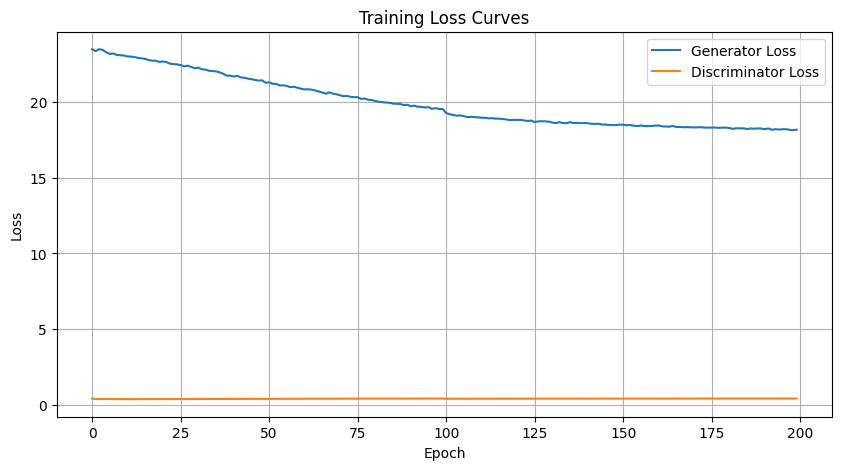

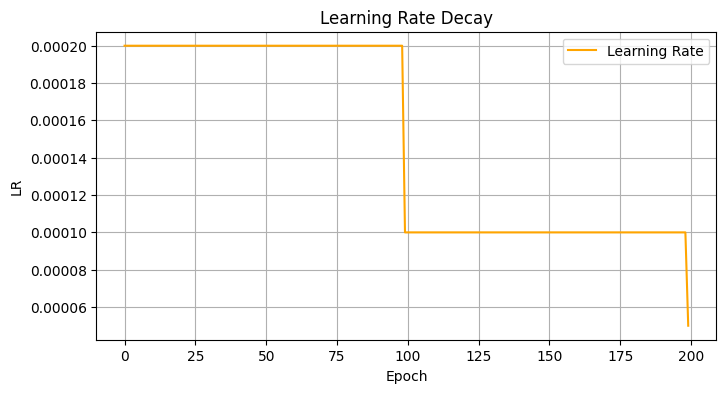

In [ ]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot learning rate decay
plt.figure(figsize=(8,4))
plt.plot(LRs, color='orange', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Learning Rate Decay')
plt.legend()
plt.grid(True)
plt.show()

## Inference (predictions)

In [ ]:
G.eval()
for p in PRED_DIR.glob("*.jpg"):
    p.unlink()  # clean old

with torch.no_grad():
    for cond, target, name in tqdm(val_loader, desc="Generating"):
        cond = cond.to(device)
        fake = G(cond).cpu()
        out = (denorm(fake[0]).permute(1,2,0).numpy()*255).astype(np.uint8)
        Image.fromarray(out).save(PRED_DIR/name[0])

print("Predictions saved to:", PRED_DIR)

Generating: 100%|██████████| 500/500 [00:09<00:00, 52.39it/s]

Predictions saved to: outputs/pred


In [ ]:
for f in tqdm(os.listdir(TEST_DIR), desc="Extracting GT photos"):
    if not f.lower().endswith(".jpg"):
        continue
    img = Image.open(os.path.join(VAL_DIR, f)).convert("RGB")
    w, h = img.size
    w2 = w // 2
    gt_photo = img.crop((0, 0, w2, h))
    gt_photo.save(os.path.join(GT_PHOTOS_DIR, f))

print("\n The Ground-truth photos saved to:", GT_PHOTOS_DIR)

Extracting GT photos: 100%|██████████| 500/500 [00:04<00:00, 124.34it/s]


 The Ground-truth photos saved to: outputs/gt_photos
